# Dataset Overview

The Human Activity Recognition Trondheim (HARTH) dataset comprises recordings from 22 participants, each wearing two 3-axial Axivity AX3 accelerometers for approximately 2 hours in a free-living environment. The sensors, positioned on the right thigh and lower back, capture motion data essential for human activity recognition (HAR). This dataset's rich, professionally annotated data offers a comprehensive benchmark for developing advanced machine learning models aimed at precise HAR in real-world settings.

- **Subject Area**: Computer Science, specifically focused on Human Activity Recognition.
- **Dataset Characteristics**: Multivariate, Time-Series.
- **Associated Tasks**: Classification.
- **Feature Type**: Real-valued sensor data.
- **Sampling Rate**: 50Hz.
- **Annotations**: Activities annotated frame-by-frame using video recordings from a chest-mounted camera.
- **Total Instances**: 6,461,328.
- **Total Features**: 8, including sensor readings (`back_x`, `back_y`, `back_z`, `thigh_x`, `thigh_y`, `thigh_z`) and activting models.


## Import Libraries


In [1]:
import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import tensorflow as tf
import zipfile
import warnings
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, TimeDistributed
from keras.models import Sequential
from keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Dropout, BatchNormalization, Bidirectional
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

## Load the Dataset

In [2]:
# URL for UCI data
zip_file_url = "https://archive.ics.uci.edu/static/public/779/harth.zip"
files = [
    'S029.csv', 'S028.csv', 'S027.csv', 'S026.csv', 'S025.csv',
    'S024.csv', 'S023.csv', 'S022.csv', 'S021.csv', 'S020.csv',
    'S019.csv', 'S018.csv', 'S017.csv', 'S016.csv', 'S015.csv',
    'S014.csv', 'S013.csv', 'S012.csv', 'S010.csv', 'S009.csv',
    'S008.csv', 'S006.csv',
]
data_types = {
    'back_x': 'float64', 'back_y': 'float64', 'back_z': 'float64',
    'thigh_x': 'float64', 'thigh_y': 'float64', 'thigh_z': 'float64',
    'label': 'int32'
}

dataframes = []
response = requests.get(zip_file_url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    for file_name in files:
        with zip_file.open('harth/' + file_name) as csv_file:
            df = pd.read_csv(csv_file, dtype=data_types, header=0)
            print(f"Loaded {file_name} with shape: {df.shape}")
            if df.empty:
                print(f"Warning: {file_name} is empty.")
            dataframes.append(df)

combined_df = pd.concat(dataframes, ignore_index=True)
print(f"Combined DataFrame shape: {combined_df.shape}")
if combined_df.empty:
    raise ValueError("The combined DataFrame is empty. Check if the files are being loaded correctly.")

Loaded S029.csv with shape: (178716, 8)
Loaded S028.csv with shape: (165178, 8)
Loaded S027.csv with shape: (158584, 8)
Loaded S026.csv with shape: (195172, 8)
Loaded S025.csv with shape: (231729, 8)
Loaded S024.csv with shape: (170534, 8)
Loaded S023.csv with shape: (137646, 9)
Loaded S022.csv with shape: (337602, 8)
Loaded S021.csv with shape: (302247, 9)
Loaded S020.csv with shape: (371496, 8)
Loaded S019.csv with shape: (297945, 8)
Loaded S018.csv with shape: (322271, 8)
Loaded S017.csv with shape: (366609, 8)
Loaded S016.csv with shape: (355418, 8)
Loaded S015.csv with shape: (418392, 9)
Loaded S014.csv with shape: (366487, 8)
Loaded S013.csv with shape: (369077, 8)
Loaded S012.csv with shape: (382414, 8)
Loaded S010.csv with shape: (351649, 8)
Loaded S009.csv with shape: (154464, 8)
Loaded S008.csv with shape: (418989, 8)
Loaded S006.csv with shape: (408709, 8)
Combined DataFrame shape: (6461328, 10)


## Add Metadata
Adding labels to the dataset for readability.


In [3]:
activity_labels = {
    1: 'walking',
    2: 'running',
    3: 'shuffling',
    4: 'stairs (ascending)',
    5: 'stairs (descending)',
    6: 'standing',
    7: 'sitting',
    8: 'lying',
    13: 'cycling (sit)',
    14: 'cycling (stand)',
    130: 'cycling (sit, inactive)',
    140: 'cycling (stand, inactive)'
}
combined_df['label'] = combined_df['label'].map(activity_labels)

## Initial Data Exploration
Here we check basic information about the data, including the first few rows and descriptive statistics.


In [4]:
print('Data Info')
print(combined_df.info())
print('Data Head')
print(combined_df.head())
print('Data Describe')
print(combined_df.describe())


Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6461328 entries, 0 to 6461327
Data columns (total 10 columns):
 #   Column      Dtype  
---  ------      -----  
 0   timestamp   object 
 1   back_x      float64
 2   back_y      float64
 3   back_z      float64
 4   thigh_x     float64
 5   thigh_y     float64
 6   thigh_z     float64
 7   label       object 
 8   Unnamed: 0  float64
 9   index       float64
dtypes: float64(8), object(2)
memory usage: 493.0+ MB
None
Data Head
                 timestamp    back_x    back_y    back_z   thigh_x   thigh_y  \
0  2019-01-12 00:00:00.000 -1.000000 -0.071289 -0.215332 -0.997070 -0.124268   
1  2019-01-12 00:00:00.020 -1.000000 -0.084473 -0.210449 -0.964844 -0.107422   
2  2019-01-12 00:00:00.040 -0.997559 -0.111328 -0.199219 -0.971191 -0.108887   
3  2019-01-12 00:00:00.060 -1.006592 -0.139160 -0.209717 -0.986084 -0.112061   
4  2019-01-12 00:00:00.080 -1.030029 -0.140137 -0.228760 -0.985840 -0.127441   

    thigh_z     label  Unna

## Data Preprocessing
Imputing missing values and performing initial data processing steps.


In [5]:
imputer = SimpleImputer(strategy='mean')
for column in combined_df.columns:
    if combined_df[column].isnull().any():
        combined_df[column] = imputer.fit_transform(combined_df[[column]])


# Exploratory Data Analysis (EDA)


### Activity Distribution - Sensor Placement

The following diagram illustrates the placement of Axivity AX3 accelerometers on the participants:

- **Right Thigh**: Captures movements related to leg motion and activities involving the lower limb.
- **Lower Back**: Provides data on the posture and upper body movements.

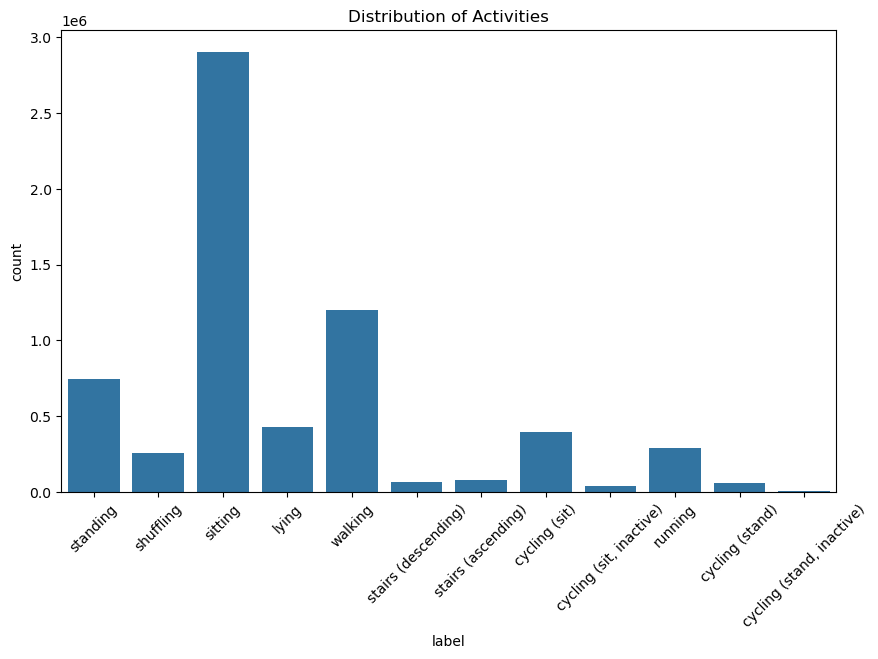

In [6]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=combined_df)
plt.xticks(rotation=45)
plt.title('Distribution of Activities')
plt.show()


## Walking Activity


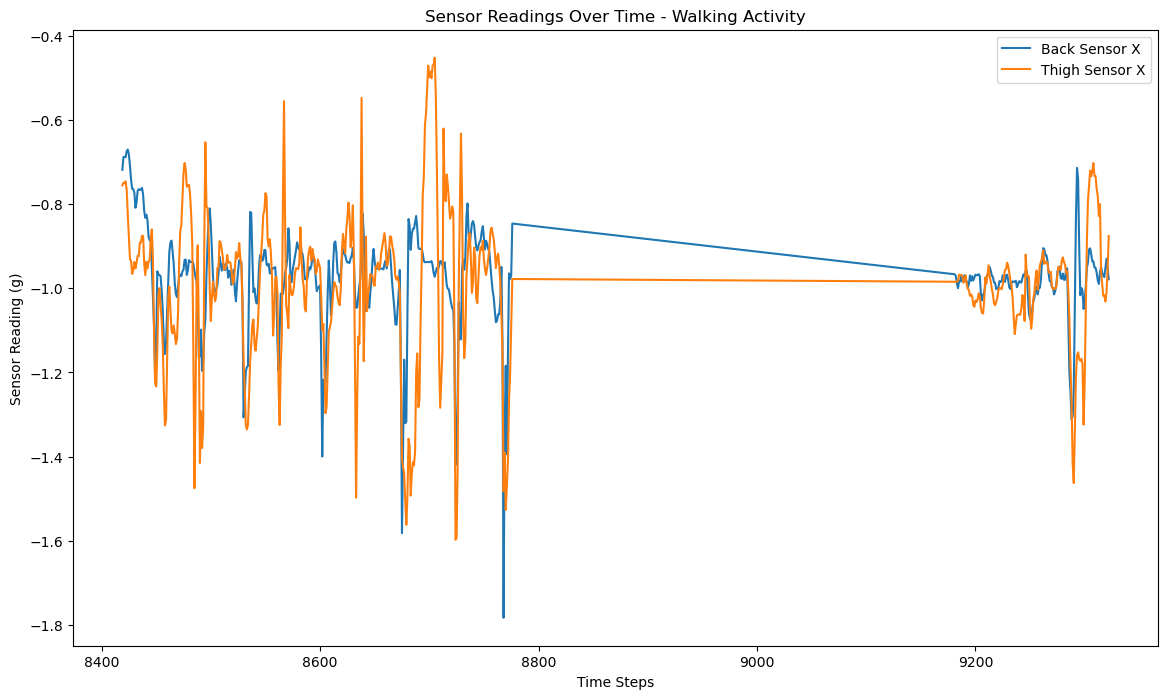

In [7]:
# Walking activity
subset_df = combined_df[combined_df['label'] == 'walking'].head(500)  # Example: first 500 instances of walking

plt.figure(figsize=(14, 8))
plt.plot(subset_df['back_x'], label='Back Sensor X')
plt.plot(subset_df['thigh_x'], label='Thigh Sensor X')
plt.title('Sensor Readings Over Time - Walking Activity')
plt.xlabel('Time Steps')
plt.ylabel('Sensor Reading (g)')
plt.legend()
plt.show()


## Running Activity
Visualizing the "running" activity can show the differences in sensor readings due to increased intensity and impact compared to walking.

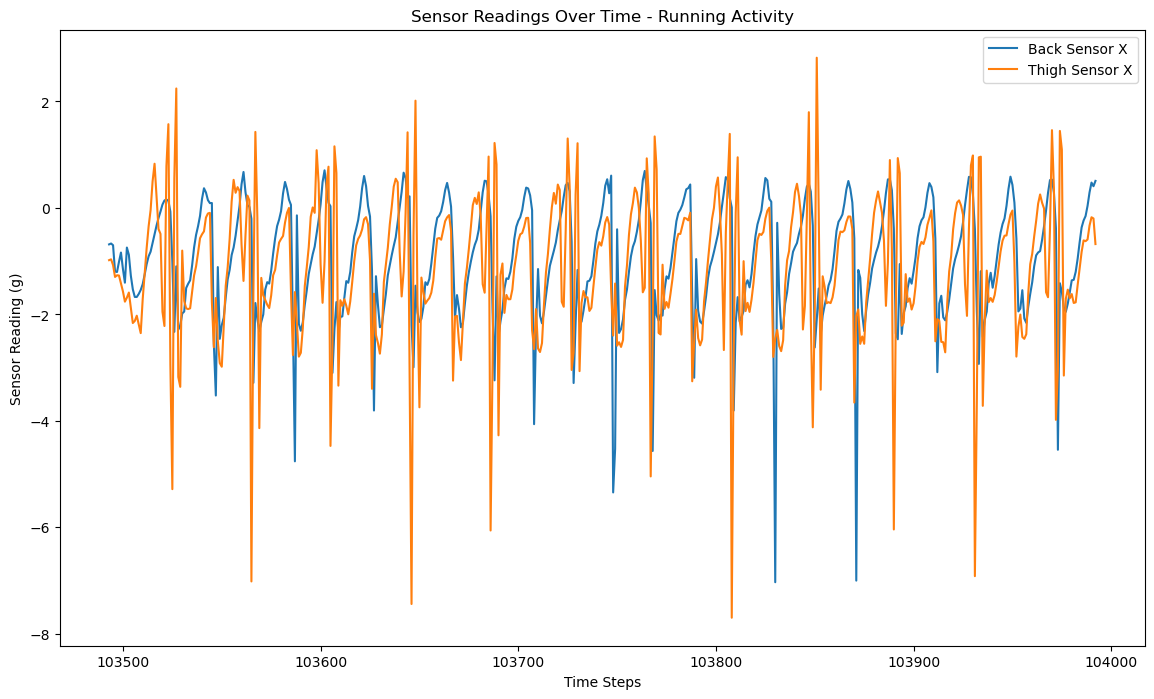

In [8]:
# Running activity
subset_df_running = combined_df[combined_df['label'] == 'running'].head(500)

plt.figure(figsize=(14, 8))
plt.plot(subset_df_running['back_x'], label='Back Sensor X')
plt.plot(subset_df_running['thigh_x'], label='Thigh Sensor X')
plt.title('Sensor Readings Over Time - Running Activity')
plt.xlabel('Time Steps')
plt.ylabel('Sensor Reading (g)')
plt.legend()
plt.show()


## Less Dynamic Activity (e.g., Sitting or Standing)
Comparing sensor data for dynamic activities (like walking and running) with less dynamic ones (like sitting or standing) can highlight the sensors' sensitivity and the potential challenges in distinguishing between low-movement activities.

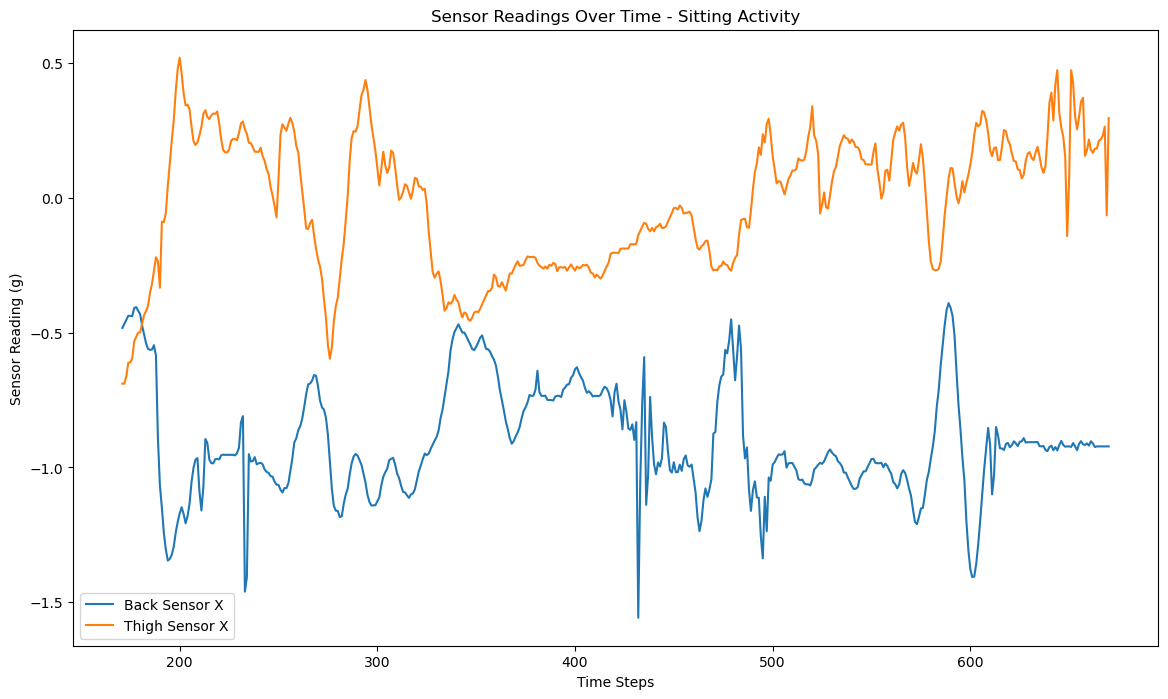

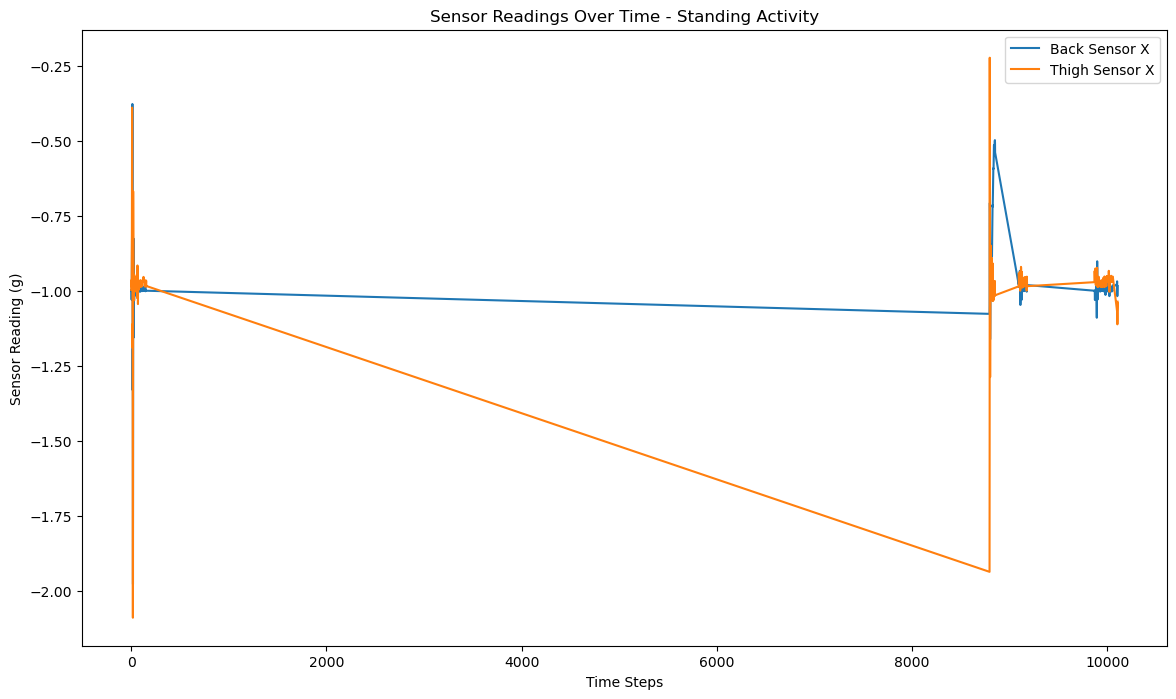

In [9]:
# Sitting activity
subset_df_sitting = combined_df[combined_df['label'] == 'sitting'].head(500)

plt.figure(figsize=(14, 8))
plt.plot(subset_df_sitting['back_x'], label='Back Sensor X')
plt.plot(subset_df_sitting['thigh_x'], label='Thigh Sensor X')
plt.title('Sensor Readings Over Time - Sitting Activity')
plt.xlabel('Time Steps')
plt.ylabel('Sensor Reading (g)')
plt.legend()
plt.show()

# Standing activity
subset_df_standing = combined_df[combined_df['label'] == 'standing'].head(500)

plt.figure(figsize=(14, 8))
plt.plot(subset_df_standing['back_x'], label='Back Sensor X')
plt.plot(subset_df_standing['thigh_x'], label='Thigh Sensor X')
plt.title('Sensor Readings Over Time - Standing Activity')
plt.xlabel('Time Steps')
plt.ylabel('Sensor Reading (g)')
plt.legend()
plt.show()


## Activity Involving Changes in Elevation (e.g., Stairs Ascending/Descending)
Activities like ascending or descending stairs involve significant changes in elevation and might show unique patterns in sensor data, particularly useful for models to learn.

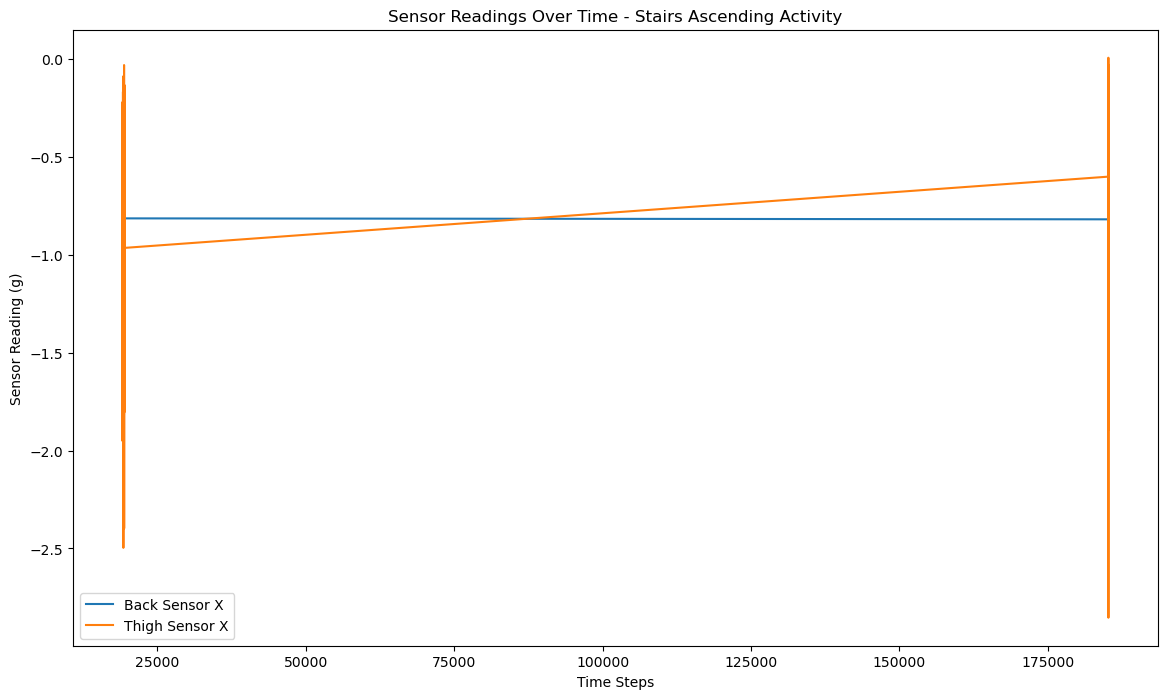

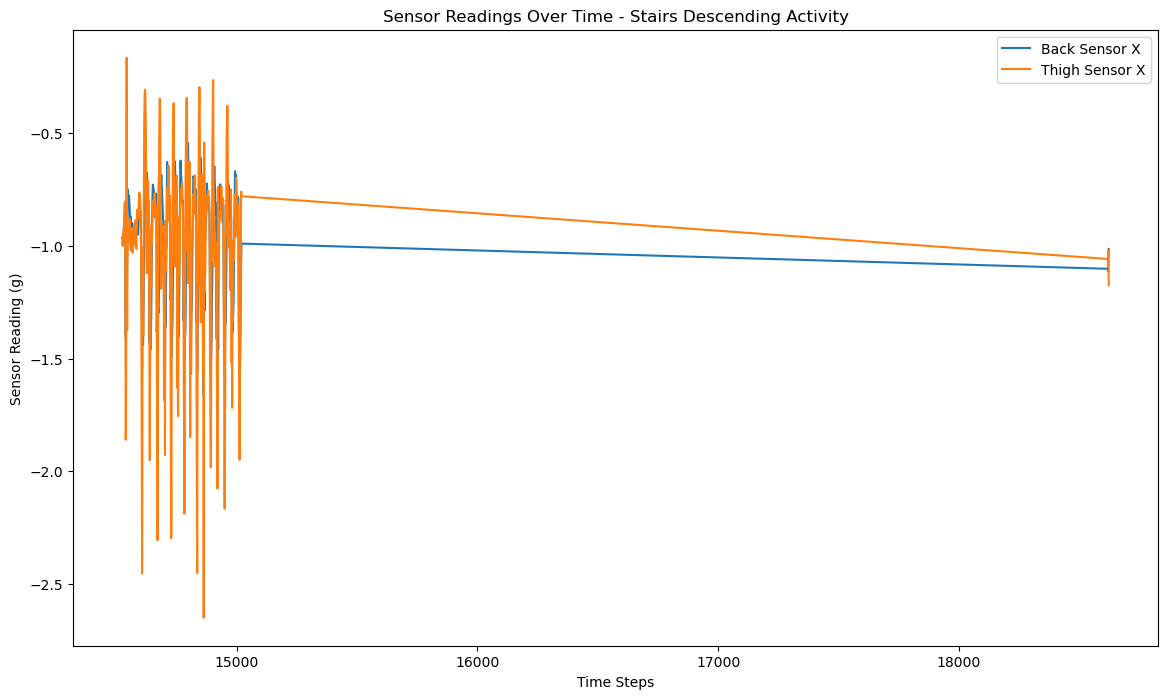

In [10]:
# Ascending activity
subset_df_stairs = combined_df[combined_df['label'] == 'stairs (ascending)'].head(500)

plt.figure(figsize=(14, 8))
plt.plot(subset_df_stairs['back_x'], label='Back Sensor X')
plt.plot(subset_df_stairs['thigh_x'], label='Thigh Sensor X')
plt.title('Sensor Readings Over Time - Stairs Ascending Activity')
plt.xlabel('Time Steps')
plt.ylabel('Sensor Reading (g)')
plt.legend()
plt.show()

# Descending activity
subset_df_descending = combined_df[combined_df['label'] == 'stairs (descending)'].head(500)

plt.figure(figsize=(14, 8))
plt.plot(subset_df_descending['back_x'], label='Back Sensor X')
plt.plot(subset_df_descending['thigh_x'], label='Thigh Sensor X')
plt.title('Sensor Readings Over Time - Stairs Descending Activity')
plt.xlabel('Time Steps')
plt.ylabel('Sensor Reading (g)')
plt.legend()
plt.show()


## Feature EngineeringWe create rolling means for sensor readings to smooth out the data and possibly highlight trends more clearly.


In [11]:
window_size = 5
combined_df['back_x_rolling_mean'] = combined_df['back_x'].rolling(window=window_size, min_periods=1).mean()
combined_df['back_y_rolling_mean'] = combined_df['back_y'].rolling(window=window_size, min_periods=1).mean()


## Outlier Detection and Removal
Removing outliers is crucial for preventing skewed analysis and improving model performance..


In [12]:
z_scores = np.abs(stats.zscore(combined_df.select_dtypes(include=[np.number])))
outlier_threshold = 3
outliers = (z_scores > outlier_threshold).any(axis=1)
combined_df = combined_df[(z_scores < outlier_threshold).all(axis=1)]
print(f"Dataframe shape after outlier removal: {combined_df.shape}")


Dataframe shape after outlier removal: (5552560, 12)


## Final Data Check
Reviewing the dataset after preprocessing steps have been applied.


In [13]:
print('Data after preprocessing:')
print(combined_df.describe())
print(combined_df.head())


Data after preprocessing:
             back_x        back_y        back_z       thigh_x       thigh_y  \
count  5.552560e+06  5.552560e+06  5.552560e+06  5.552560e+06  5.552560e+06   
mean  -9.121891e-01 -7.992054e-03 -1.731458e-01 -5.706414e-01  2.584056e-02   
std    2.348006e-01  1.268500e-01  3.470284e-01  4.961473e-01  2.298356e-01   
min   -2.017599e+00 -7.067283e-01 -1.263428e+00 -2.473884e+00 -1.144459e+00   
25%   -1.000886e+00 -7.650380e-02 -3.666099e-01 -9.721932e-01 -8.943921e-02   
50%   -9.768975e-01  3.217797e-03 -1.363663e-01 -4.392341e-01  3.133353e-02   
75%   -8.587360e-01  6.668591e-02  4.653901e-02 -1.898373e-01  1.442549e-01   
max    2.478030e-01  6.802036e-01  9.248176e-01  1.284136e+00  1.186203e+00   

            thigh_z    Unnamed: 0         index  back_x_rolling_mean  \
count  5.552560e+06  5.552560e+06  5.552560e+06         5.552560e+06   
mean   4.172633e-01  6.882788e+04  1.955996e+05        -9.190345e-01   
std    6.480541e-01  7.000241e+02  1.690038e+0

# Data Visualization 

## Correlation Heatmap
A correlation heatmap provides a visual representation of how the features correlate with each other.

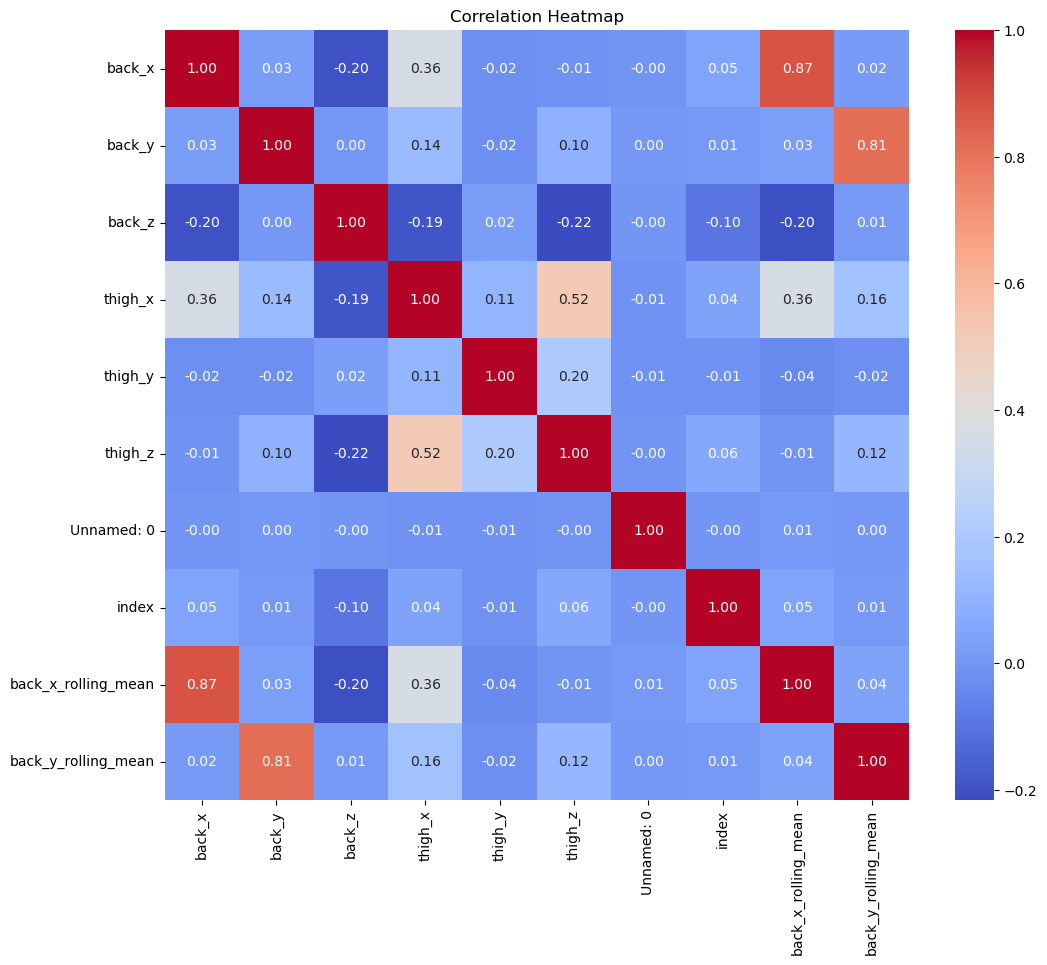

In [14]:
# Correlation Heatmap with explicit numeric_only parameter
plt.figure(figsize=(12, 10))
correlation_matrix = combined_df.corr(numeric_only=True)  # Explicitly specify numeric_only=True
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

## Pair Plots
Pair plots allow us to see both the distribution of single variables and relationships between two variables.

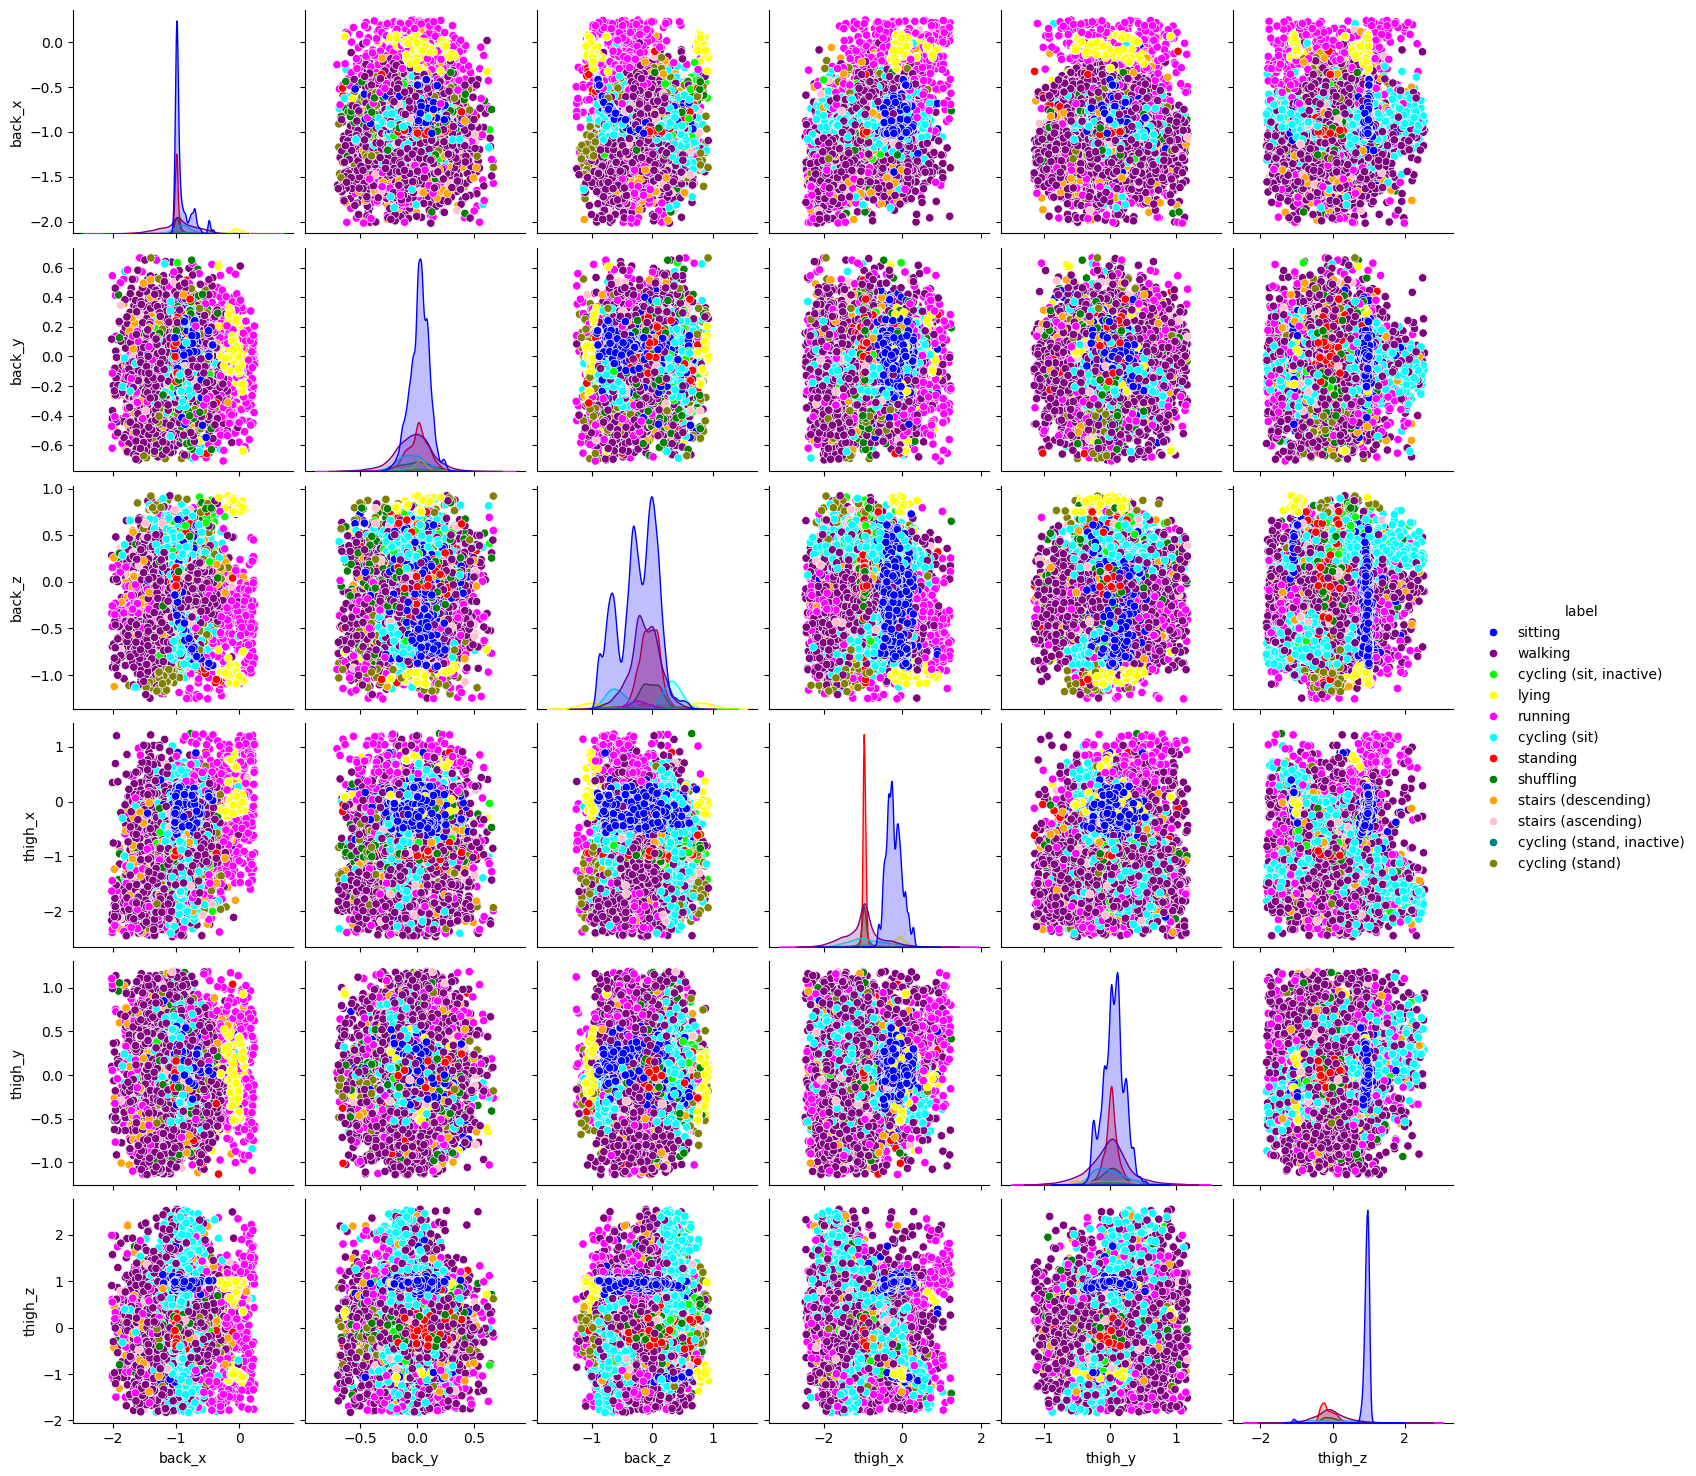

In [15]:
# Define a custom color palette with the provided 12 distinct colors
custom_colors = [
    "#FF0000",  # Red
    "#008000",  # Green
    "#0000FF",  # Blue
    "#FFFF00",  # Yellow
    "#800080",  # Purple
    "#FFA500",  # Orange
    "#FFC0CB",  # Pink
    "#00FFFF",  # Cyan
    "#00FF00",  # Lime
    "#FF00FF",  # Magenta
    "#808000",  # Olive
    "#008080"   # Teal
]

# Ensure that we have a unique color for each label
unique_labels = combined_df['label'].unique()
palette_dict = dict(zip(unique_labels, custom_colors * (len(unique_labels) // len(custom_colors) + 1)))

# Sample a fraction of the dataframe for the pair plot
sample_df = combined_df.sample(frac=0.01, random_state=42)  # Adjust as needed

# Create the pair plot with the custom palette
sns.pairplot(sample_df, hue='label', vars=['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z'], palette=palette_dict)

# Show the plot
plt.show()

## Box Plots
Box plots for sensor readings by activity can help identify variations across different activities and potential outliers.

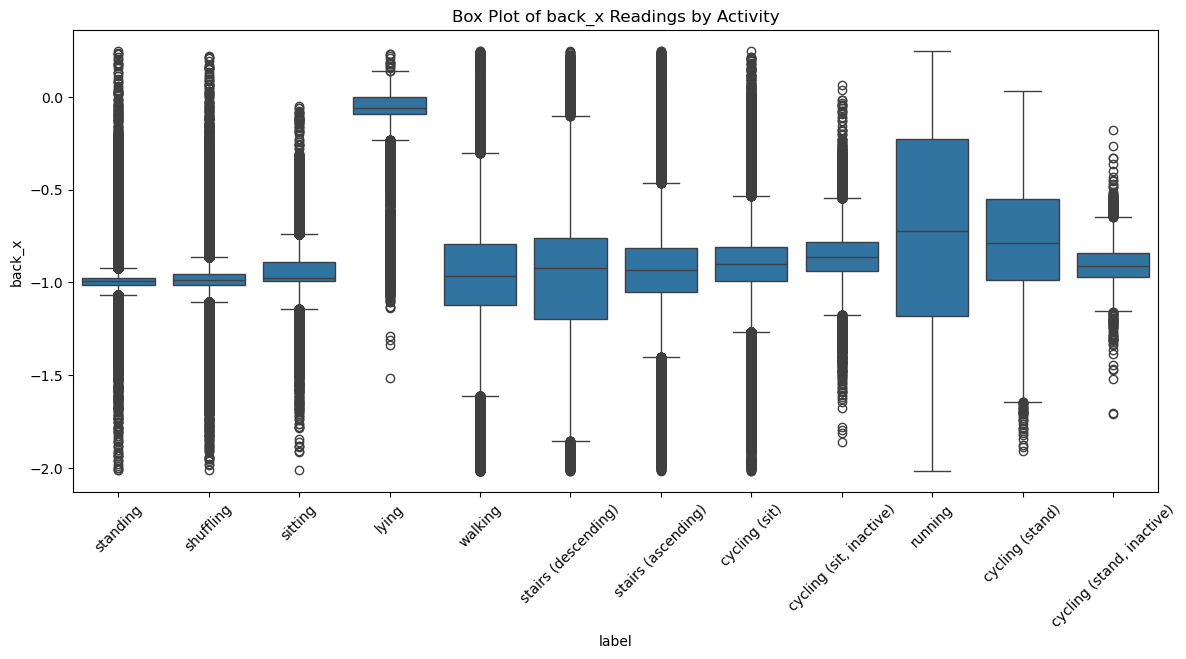

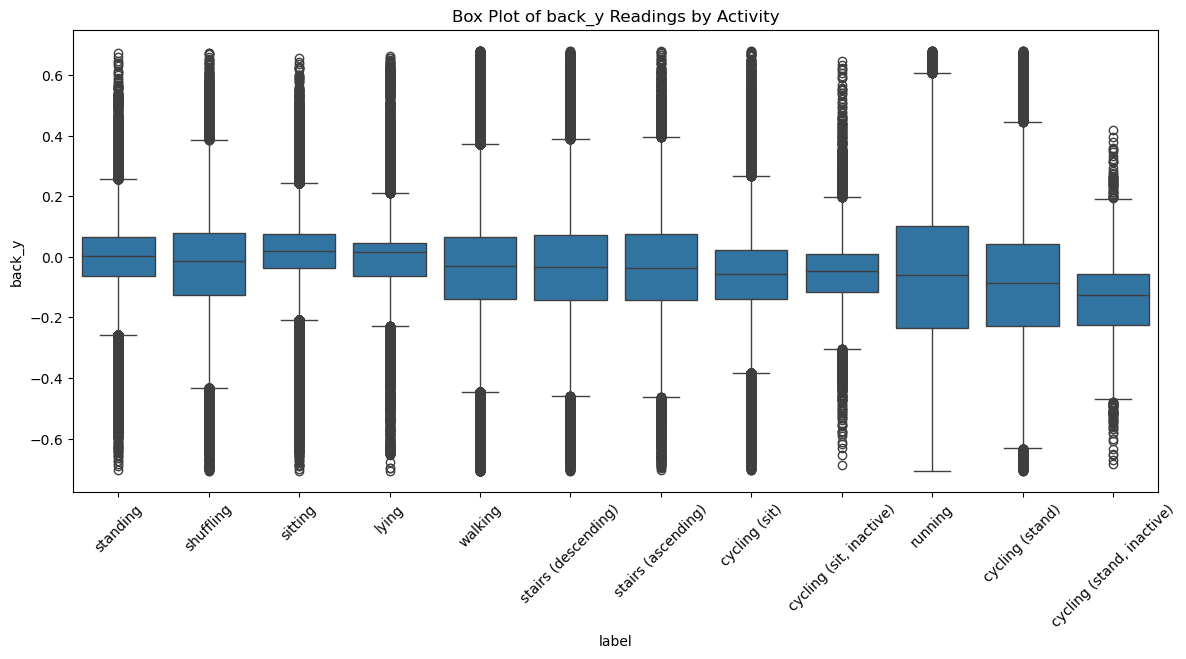

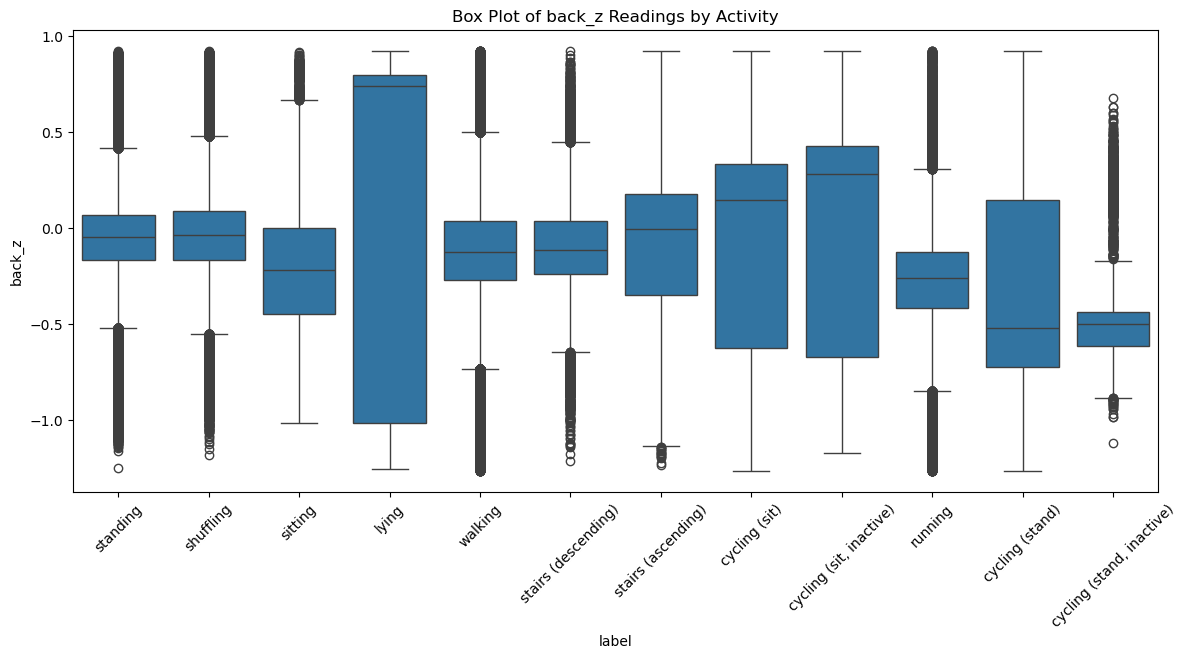

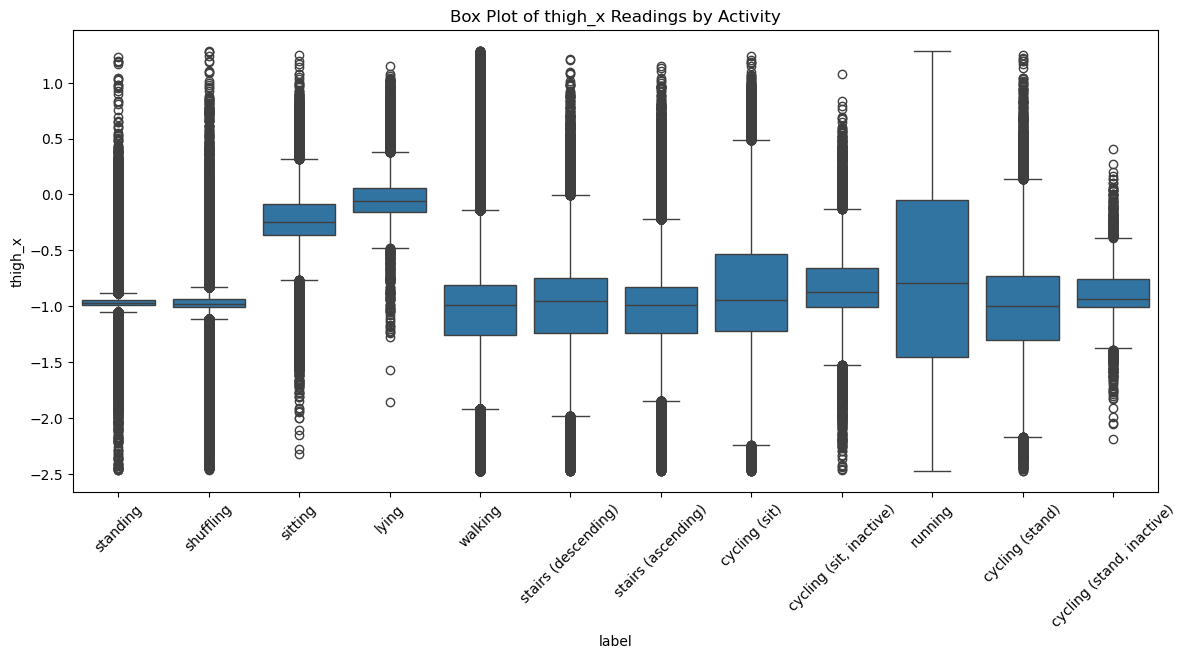

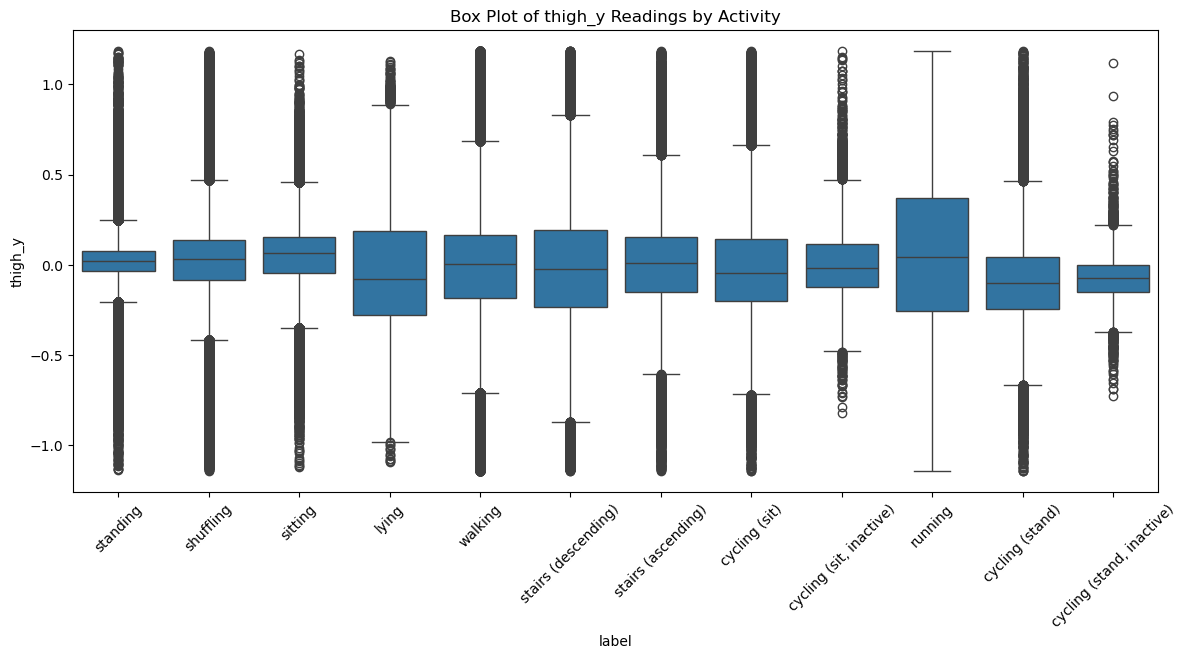

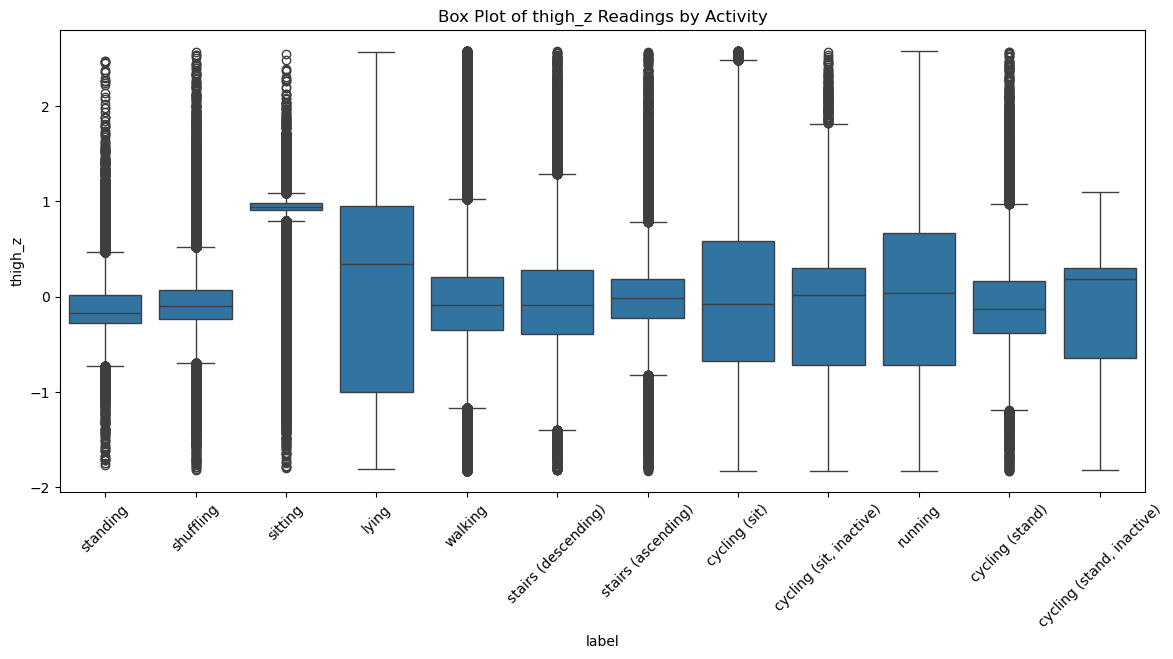

In [16]:
# List of sensor columns to plot
sensor_columns = ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']

for sensor in sensor_columns:
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='label', y=sensor, data=combined_df)
    plt.xticks(rotation=45)
    plt.title(f'Box Plot of {sensor} Readings by Activity')
    plt.show()


## Density Plots
Density plots are useful for comparing the distribution of sensor readings across different activities.

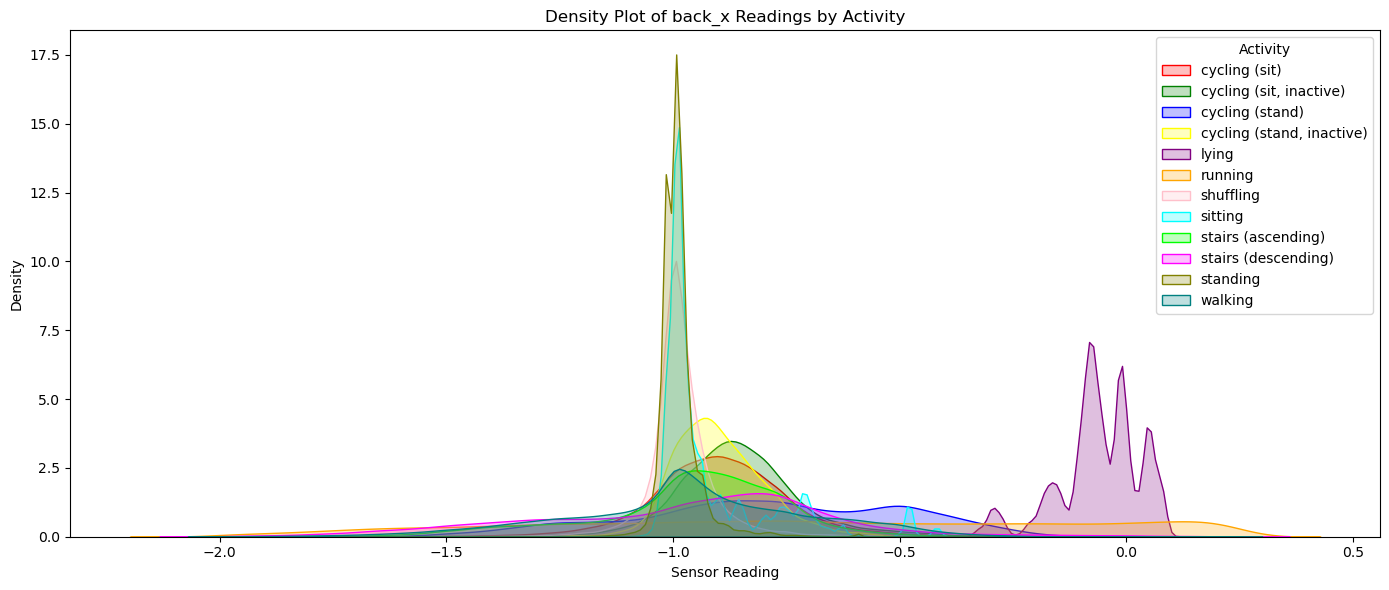

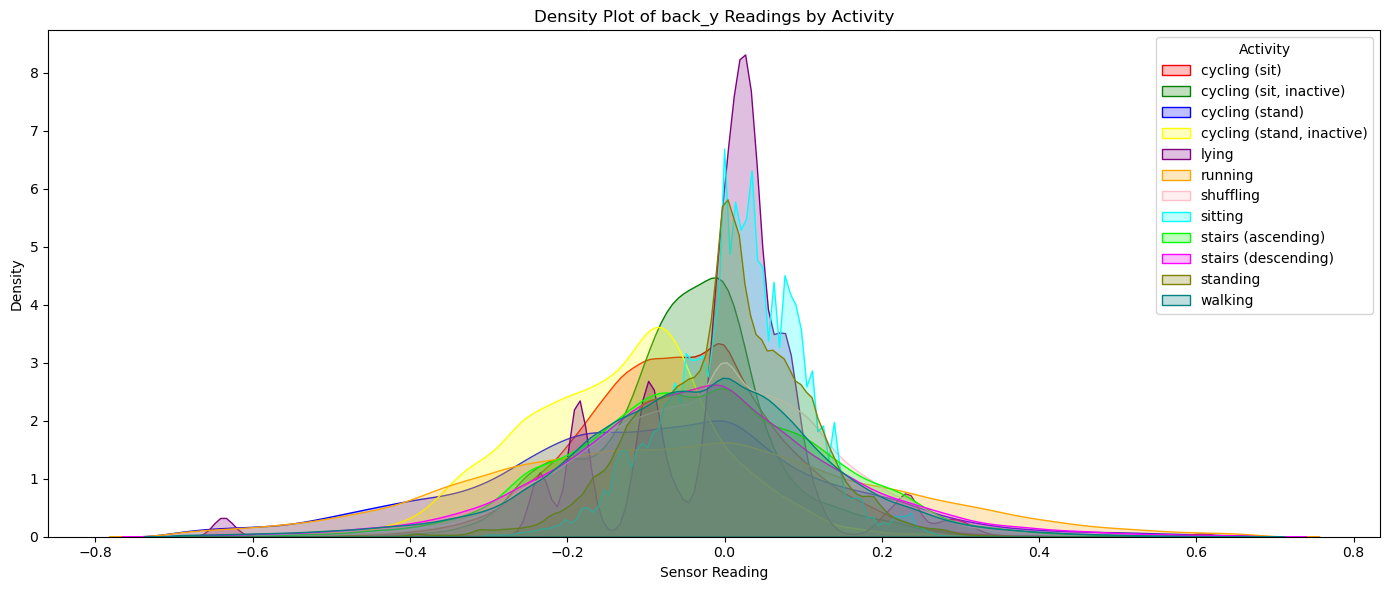

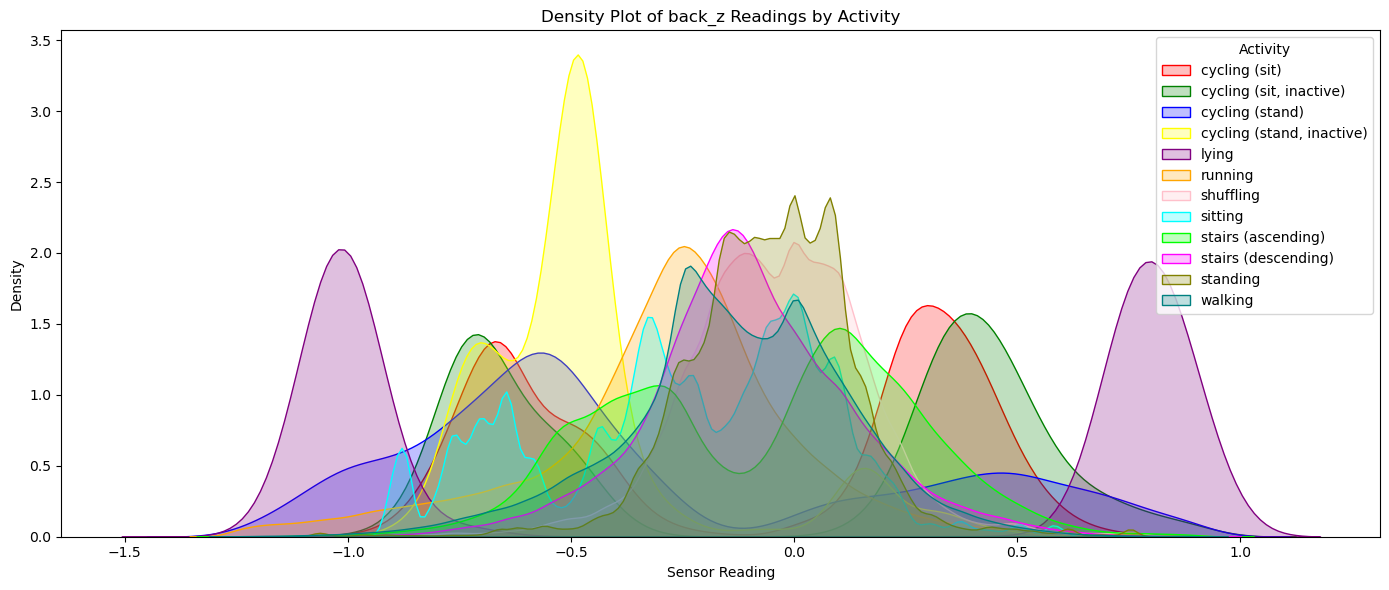

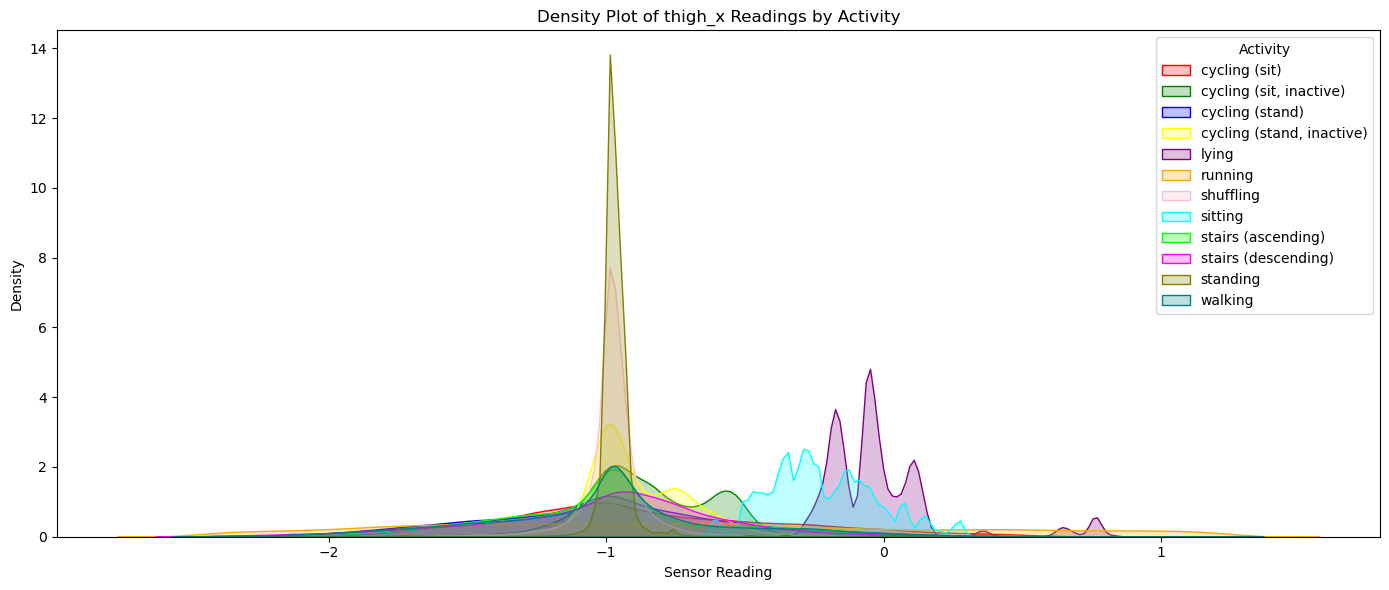

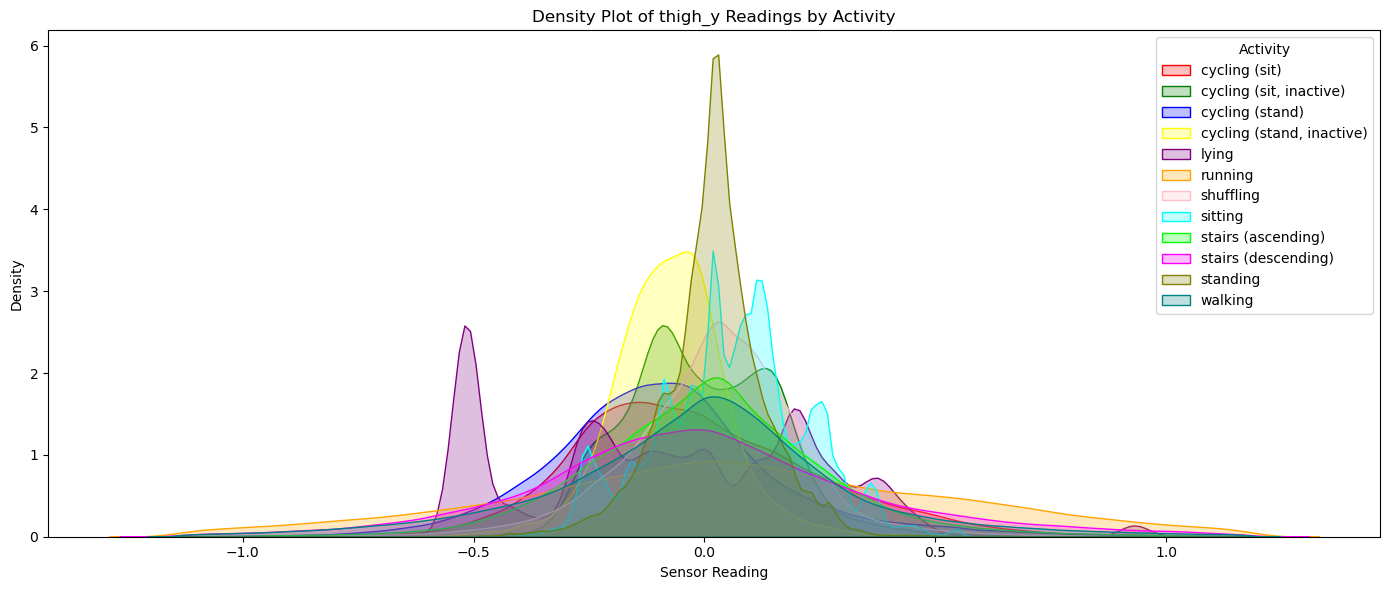

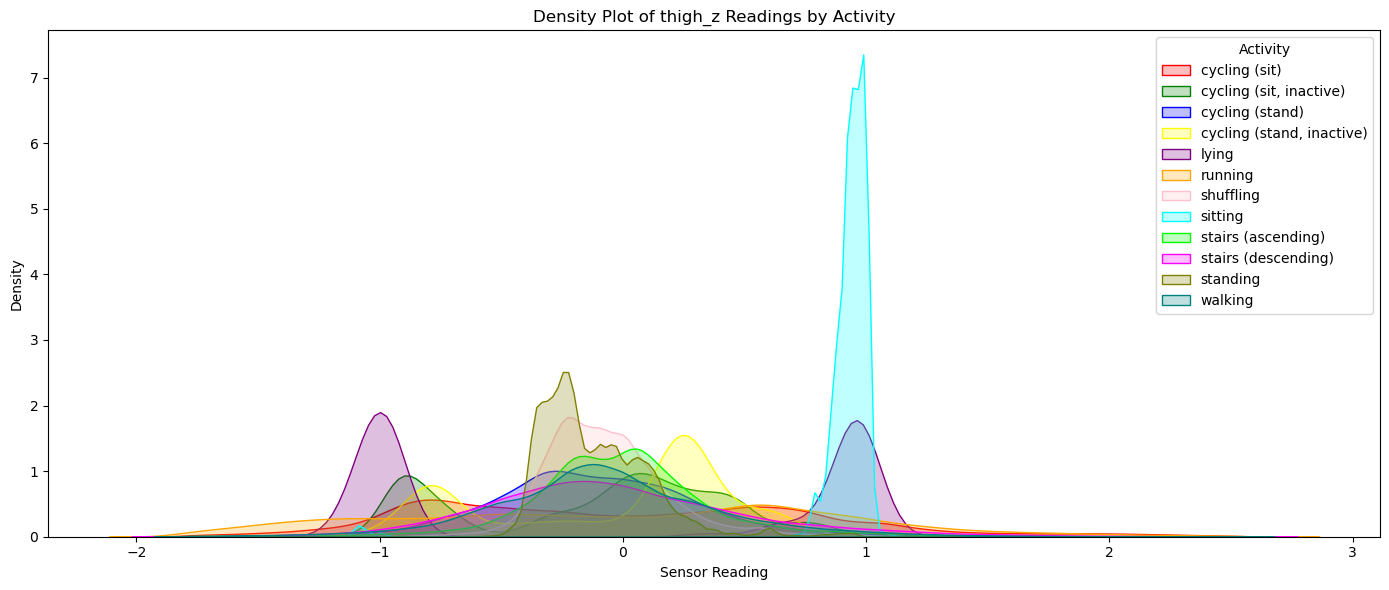

In [17]:
# Ensure that we have a unique color for each label
unique_labels = sorted(combined_df['label'].unique())
palette_dict = dict(zip(unique_labels, custom_colors * (len(unique_labels) // len(custom_colors) + 1)))

# Density Plots for all sensor readings
for sensor in sensor_columns:
    plt.figure(figsize=(14, 6))
    for activity in unique_labels:
        subset = combined_df[combined_df['label'] == activity]
        if subset[sensor].var() > 0:  # Check if variance is greater than 0
            sns.kdeplot(subset[sensor], label=str(activity), fill=True, color=palette_dict[activity])
    plt.title(f'Density Plot of {sensor} Readings by Activity')
    plt.xlabel('Sensor Reading')
    plt.ylabel('Density')
    plt.legend(title='Activity')
    plt.tight_layout()  # Adjust the layout to fit everything
    plt.show()


## Violin Plots
Violing plots provide a holistic view of the data's distribution, help in understanding its characteristics, and can guide preprocessing and analysis decisions.

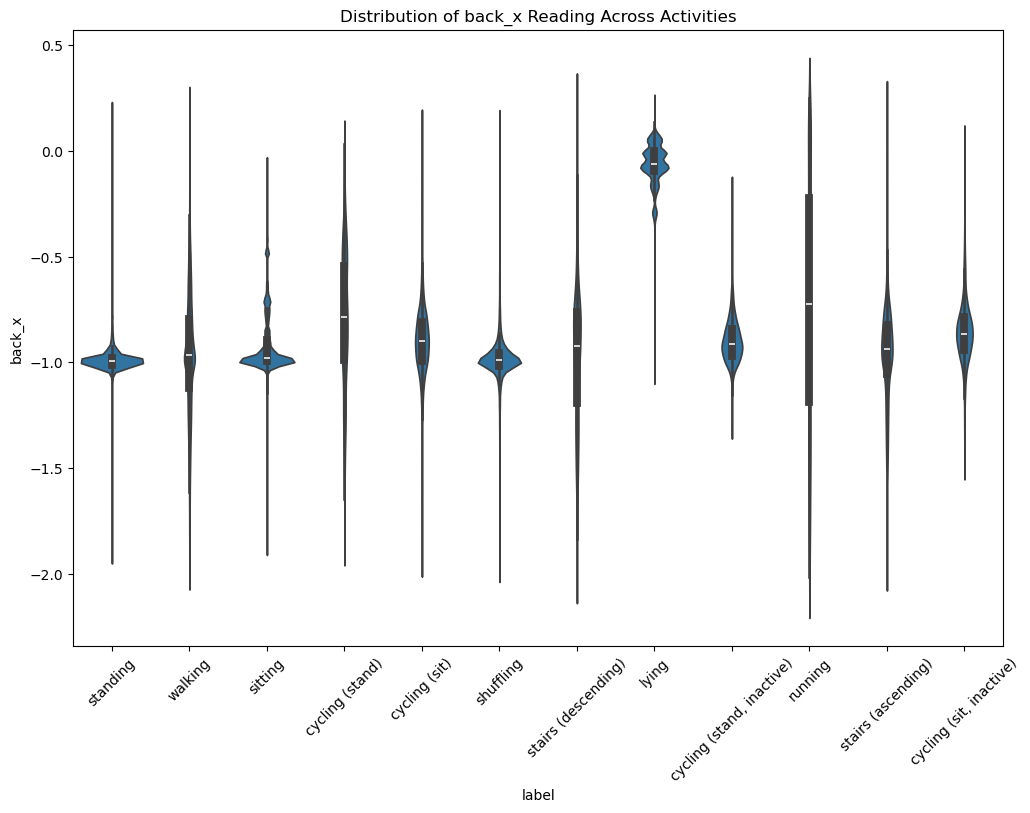

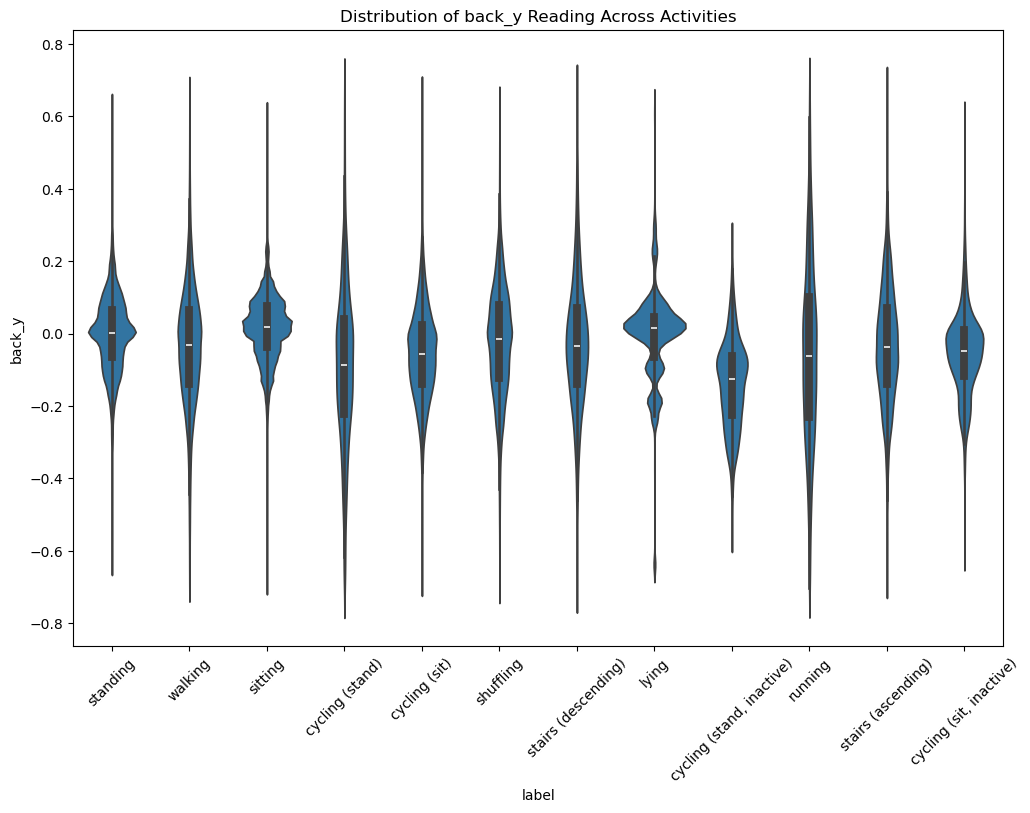

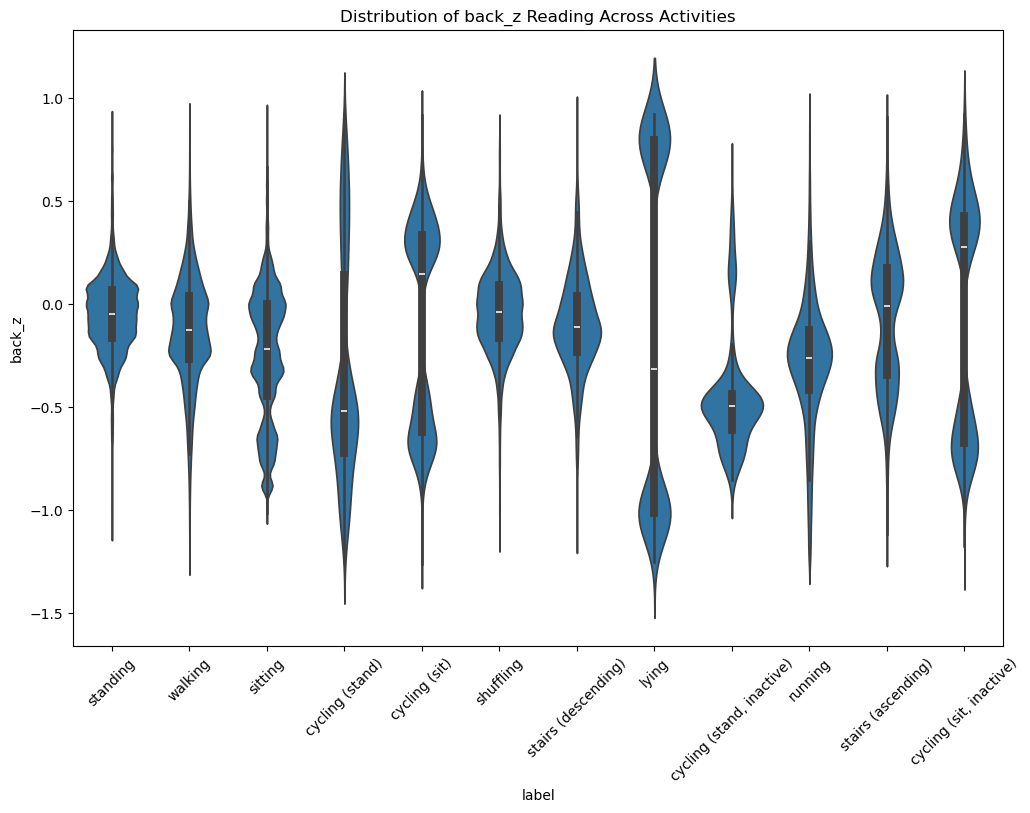

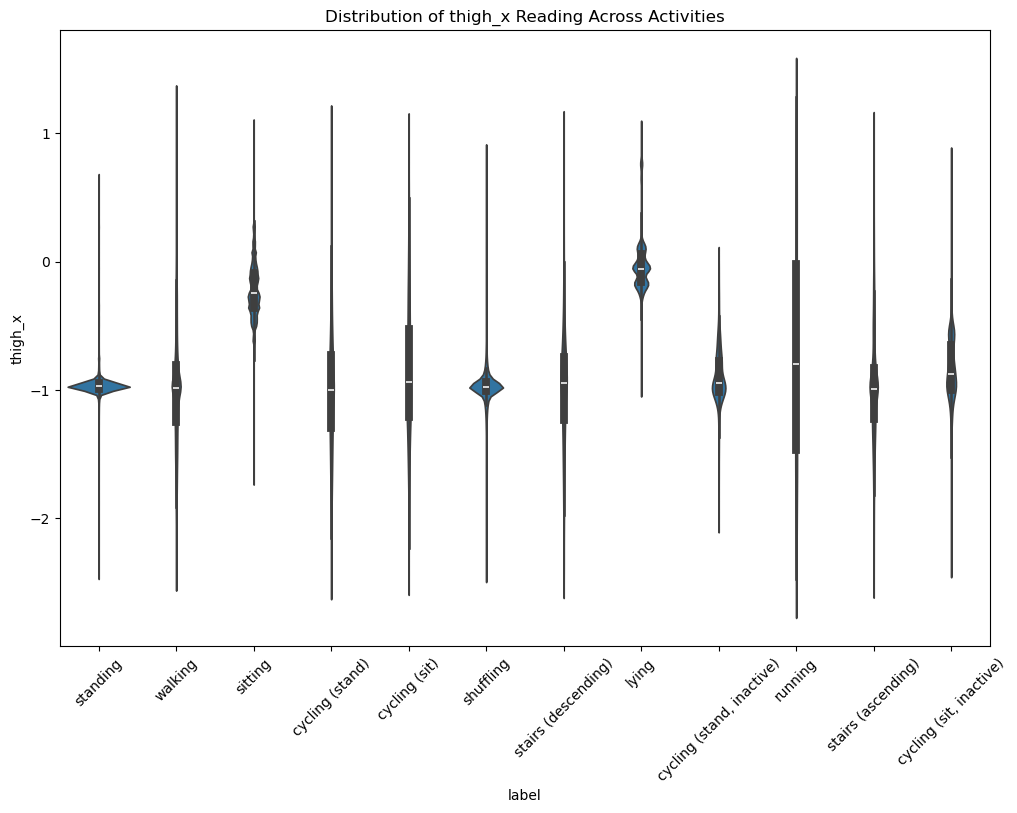

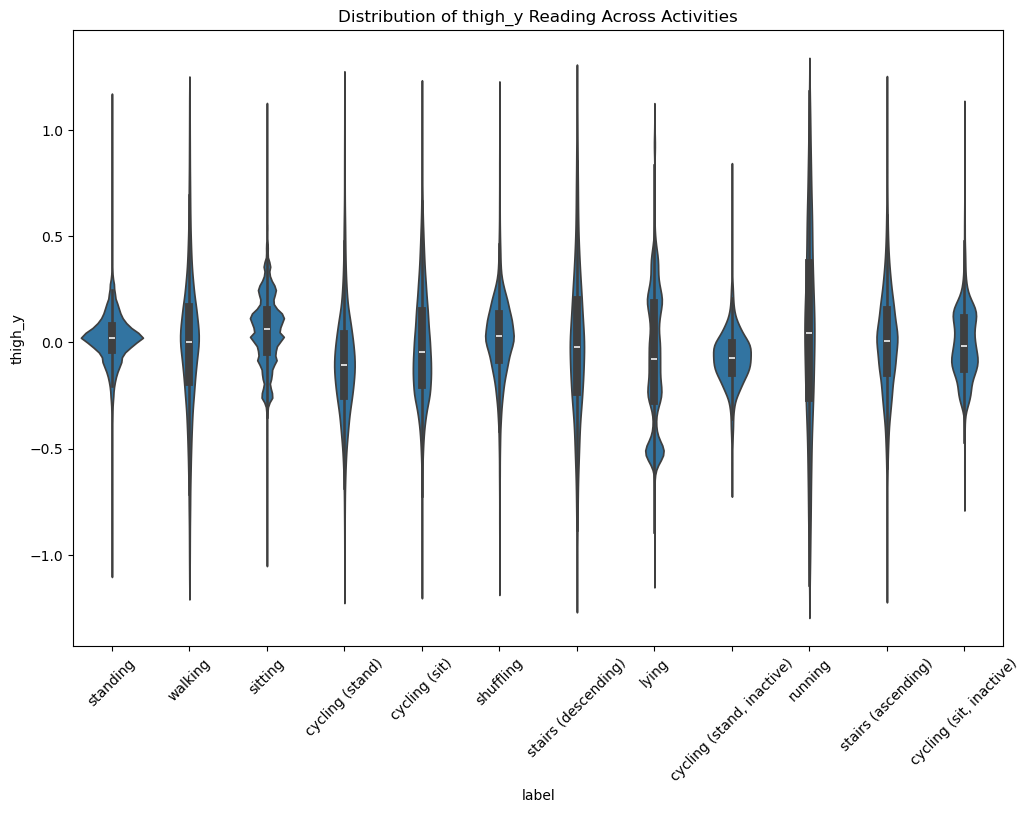

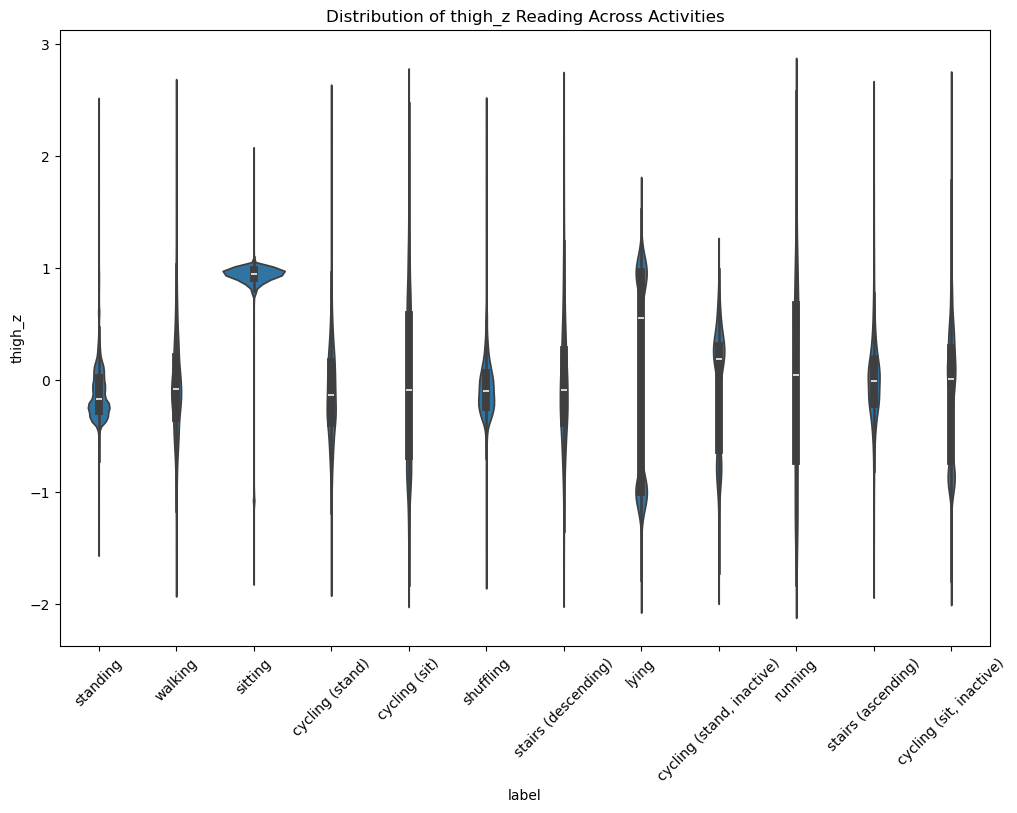

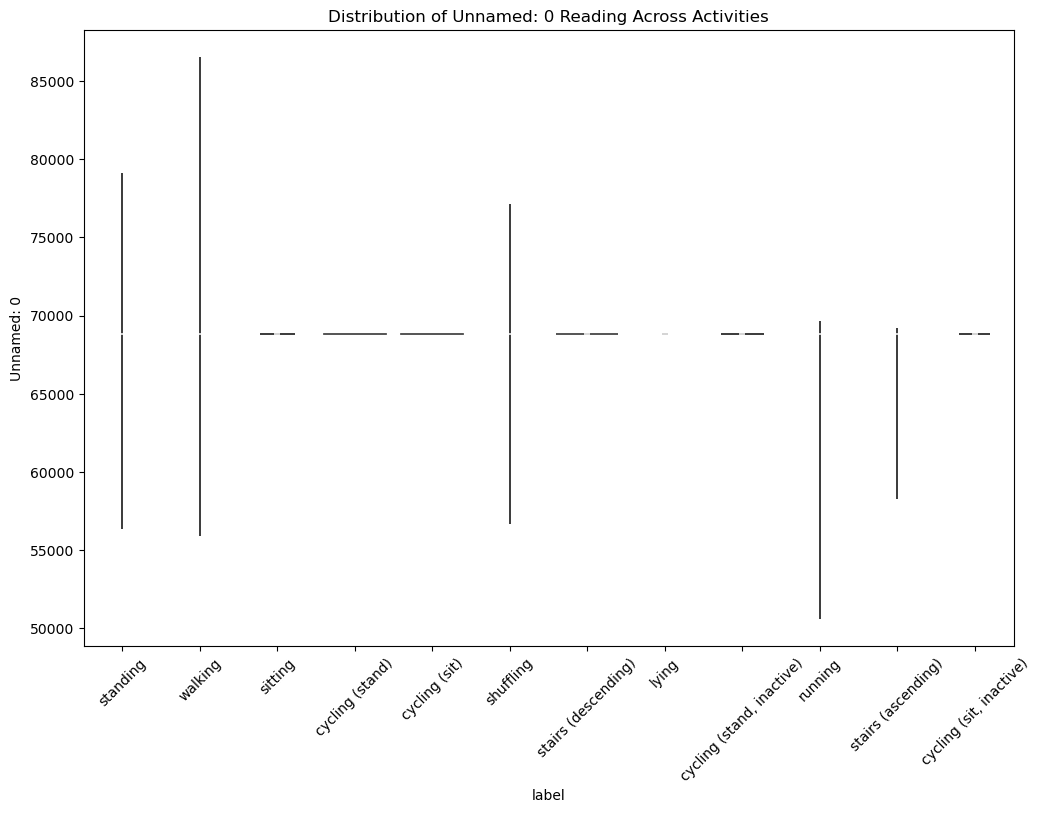

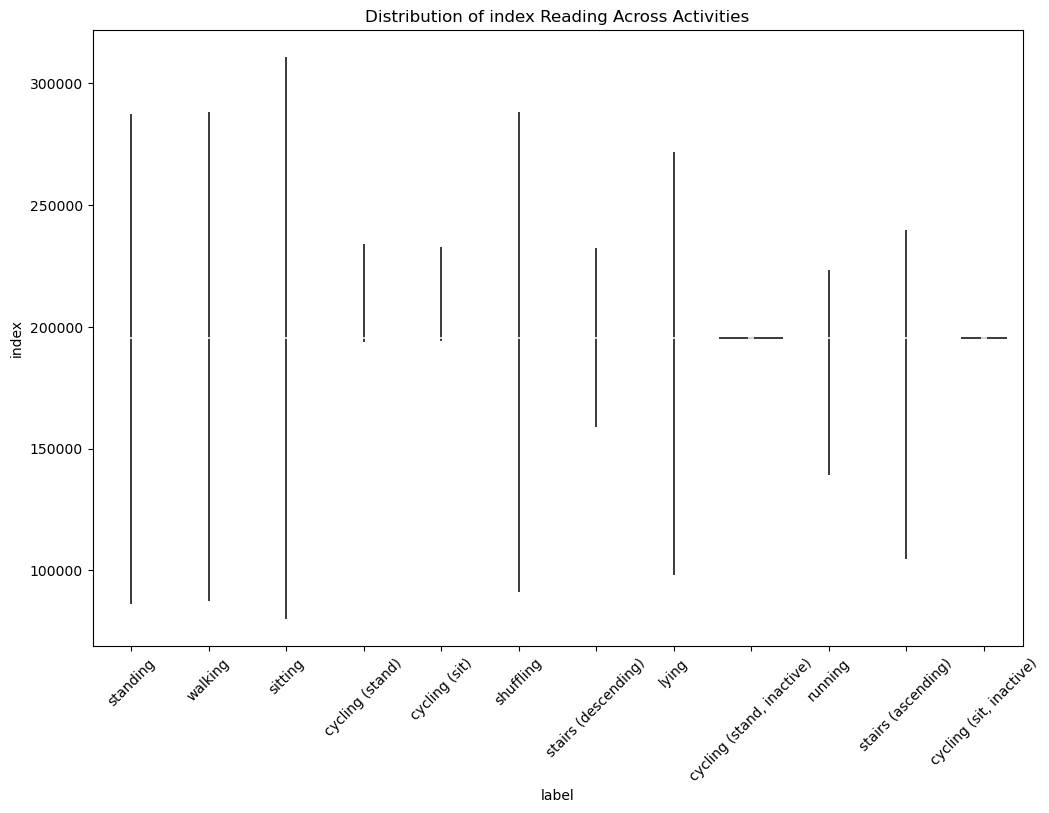

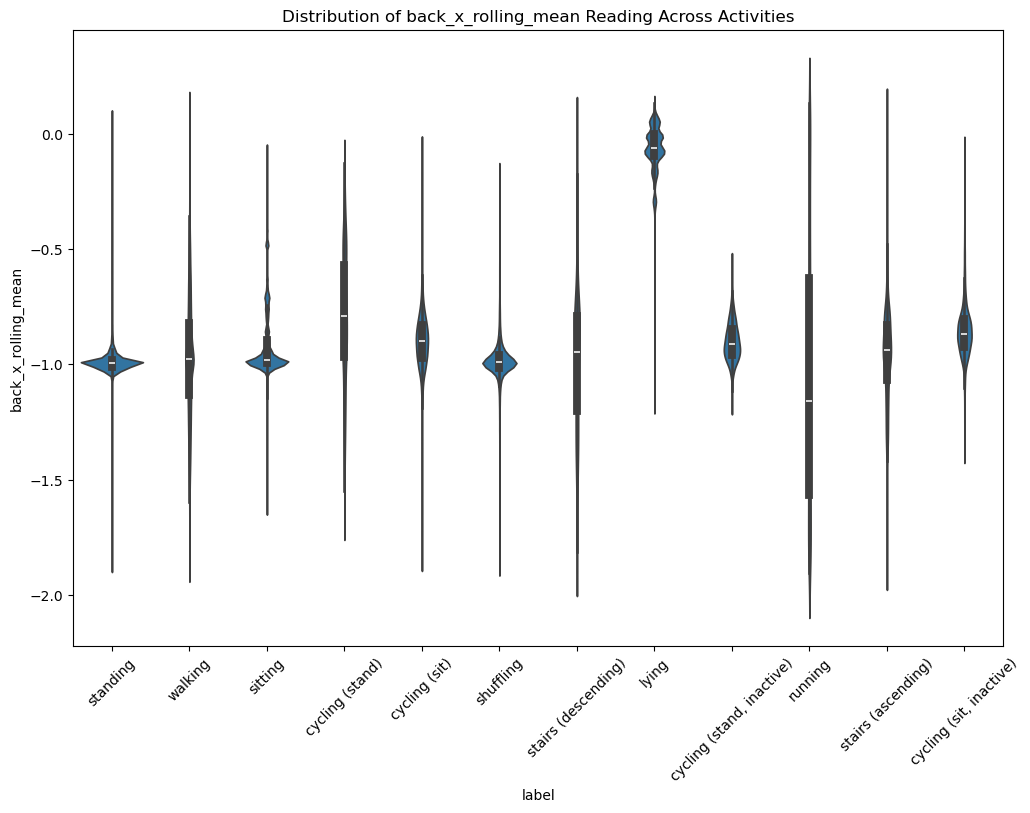

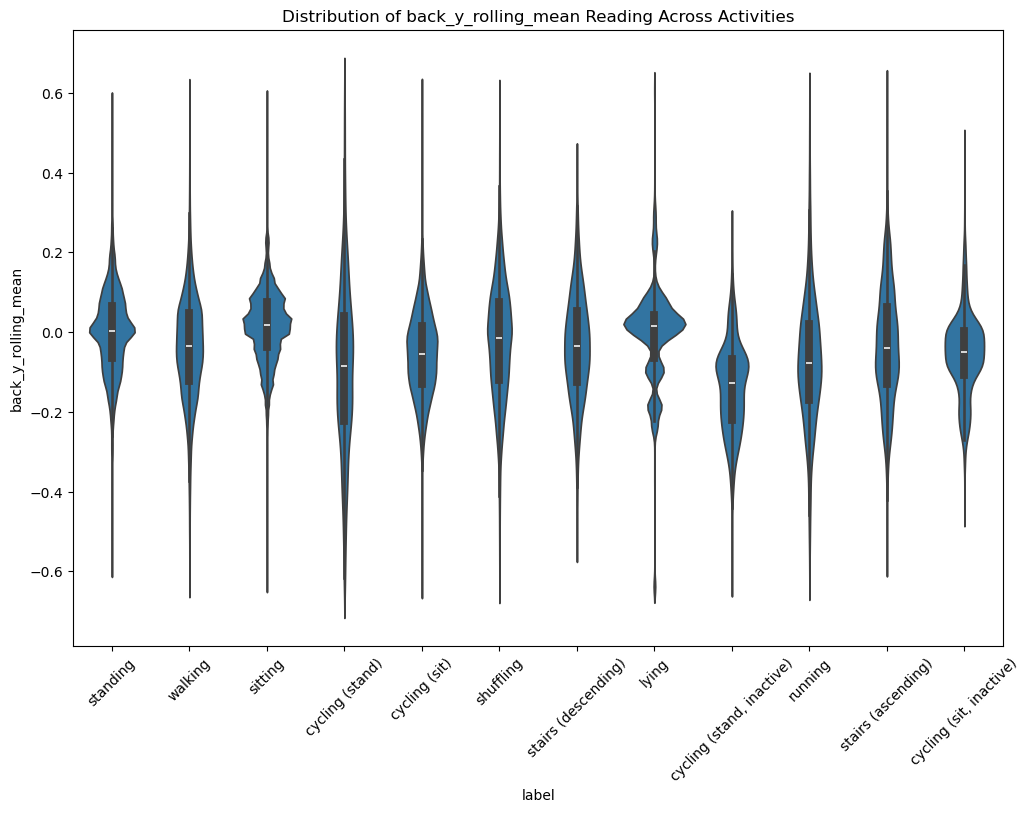

In [18]:
# Function to create a violin plot for a sensor column
def create_violin_plot(df, sensor_column):
    plt.figure(figsize=(12, 8))
    sns.violinplot(x='label', y=sensor_column, data=df)
    plt.xticks(rotation=45)
    plt.title(f'Distribution of {sensor_column} Reading Across Activities')
    plt.show()

# Sample a subset of data
sampled_df = combined_df.sample(frac=0.1)  # Adjust the fraction as needed

# Filter only numeric columns for sensor data in the sampled dataframe
sampled_sensor_columns = [col for col in sampled_df.columns if sampled_df[col].dtype in ['int64', 'float64'] and col != 'label']

# Create violin plots for each sensor column
for sensor in sampled_sensor_columns:
    create_violin_plot(sampled_df, sensor)


# Deep Learning Model 1: Convolutional Neural Network (CNN) for Human Activity Recognition (HAR)  function.


In [19]:
# Filter only numeric columns for sensor data
sensor_columns = [col for col in combined_df.columns if combined_df[col].dtype in ['int64', 'float64'] and col != 'label']

# Data Preparation
X = combined_df[sensor_columns].values
y = combined_df['label'].values
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define timesteps and reshape for CNN
timesteps = 200
samples = len(X_scaled) // timesteps
features = len(sensor_columns)
X_reshaped = X_scaled[:samples * timesteps].reshape((samples, timesteps, features))
y_reshaped = y_categorical[:samples]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_reshaped, test_size=0.2, random_state=42)

# CNN Model Definition
def create_cnn(timesteps, features, num_classes):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(timesteps, features)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(100, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Model Training


In [20]:
# Suppress specific TensorFlow warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="tensorflow")
warnings.filterwarnings("ignore", category=Warning, module="tensorflow")

# Model Training
cnn_model = create_cnn(timesteps, features, y_train.shape[1])
history_cnn = cnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=2)




Epoch 1/10


695/695 - 10s - loss: 1.0707 - accuracy: 0.5881 - val_loss: 0.9329 - val_accuracy: 0.6607 - 10s/epoch - 15ms/step
Epoch 2/10
695/695 - 8s - loss: 0.8217 - accuracy: 0.6889 - val_loss: 0.9139 - val_accuracy: 0.6442 - 8s/epoch - 11ms/step
Epoch 3/10
695/695 - 8s - loss: 0.7222 - accuracy: 0.7248 - val_loss: 0.8154 - val_accuracy: 0.7038 - 8s/epoch - 11ms/step
Epoch 4/10
695/695 - 8s - loss: 0.6550 - accuracy: 0.7529 - val_loss: 0.7644 - val_accuracy: 0.7180 - 8s/epoch - 11ms/step
Epoch 5/10
695/695 - 8s - loss: 0.6087 - accuracy: 0.7707 - val_loss: 0.7487 - val_accuracy: 0.7326 - 8s/epoch - 11ms/step
Epoch 6/10
695/695 - 8s - loss: 0.5722 - accuracy: 0.7837 - val_loss: 0.7149 - val_accuracy: 0.7472 - 8s/epoch - 11ms/step
Epoch 7/10
695/695 - 8s - loss: 0.5237 - accuracy: 0.8008 - val_loss: 0.7555 - val_accuracy: 0.7268 - 8s/epoch - 11ms/step
Epoch 8/10
695/695 - 8s - loss: 0.4940 - accuracy: 0.8151 - val_loss: 0.7296 - val_accuracy: 0.7412 - 8s/epoch - 11ms/step
Epoch 9/1

## Model Evaluation

174/174 [==============================] - 1s 5ms/step
CNN Model - Accuracy: 0.7516657662524762, Precision: 0.710726070626481, Recall: 0.6702192800679169, F1 Score: 0.685966265232197

Classification Report:
               precision    recall  f1-score   support

           4       0.86      0.87      0.87      1005
           6       0.63      0.58      0.60       983
           7       0.87      0.96      0.92       671
           8       0.57      0.42      0.48        72
           9       0.62      0.49      0.54       210
          10       0.74      0.82      0.78      1900
          11       0.68      0.56      0.61       712

    accuracy                           0.75      5553
   macro avg       0.71      0.67      0.69      5553
weighted avg       0.75      0.75      0.75      5553



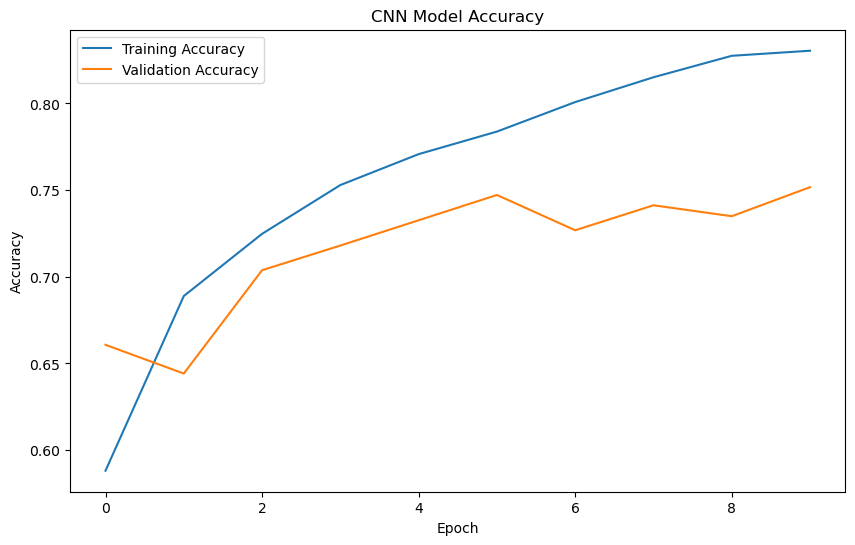

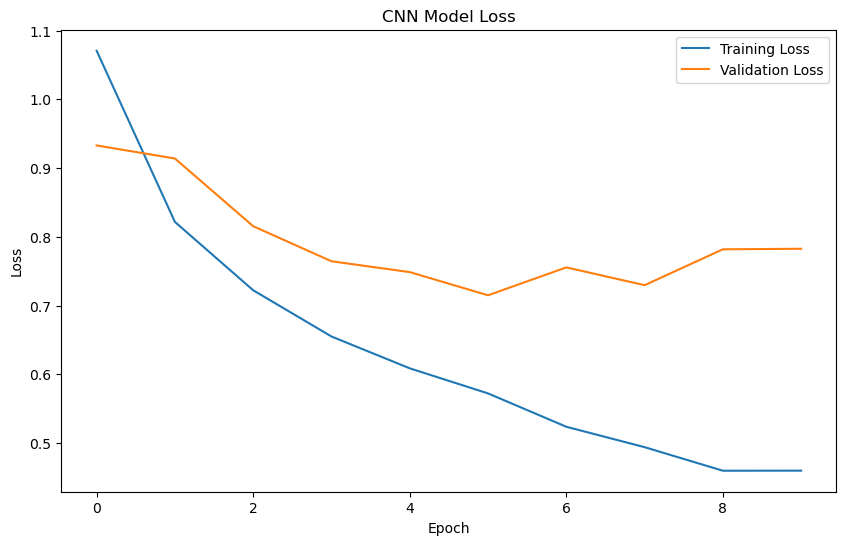

In [21]:
# Model Evaluation
y_pred_cnn = np.argmax(cnn_model.predict(X_test), axis=1)
y_true_cnn = np.argmax(y_test, axis=1)

# Calculate Metrics
accuracy_cnn = accuracy_score(y_true_cnn, y_pred_cnn)
precision_cnn = precision_score(y_true_cnn, y_pred_cnn, average='macro', zero_division=0)
recall_cnn = recall_score(y_true_cnn, y_pred_cnn, average='macro', zero_division=0)
f1_cnn = f1_score(y_true_cnn, y_pred_cnn, average='macro', zero_division=0)

# Print Metrics
print(f"CNN Model - Accuracy: {accuracy_cnn}, Precision: {precision_cnn}, Recall: {recall_cnn}, F1 Score: {f1_cnn}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_true_cnn, y_pred_cnn))

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('CNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Deep Learning Model 2: Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) for Human Activity Recognition (HAR) 

In this section, we explore the application of a Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers to recognize human activities based on time-series sensor data. The model is built and trained from scratch using TensorFlow, and its performance is evaluated against the previously implemented Convolutional Neural Network (CNN) to compare their effectiveness in the task of HAR.


In [22]:
# RNN Model Definition
def create_rnn(timesteps, features, num_classes):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(timesteps, features)),
        Dropout(0.5),
        LSTM(50),
        Dropout(0.5),
        Dense(100, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


## Model Training

In [23]:
# Model Training
rnn_model = create_rnn(timesteps, features, y_train.shape[1])
history_rnn = rnn_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), verbose=2)


Epoch 1/10
695/695 - 159s - loss: 1.3047 - accuracy: 0.5056 - val_loss: 1.1705 - val_accuracy: 0.5350 - 159s/epoch - 229ms/step
Epoch 2/10
695/695 - 144s - loss: 1.1229 - accuracy: 0.5631 - val_loss: 1.0835 - val_accuracy: 0.5745 - 144s/epoch - 208ms/step
Epoch 3/10
695/695 - 118s - loss: 1.0630 - accuracy: 0.5931 - val_loss: 0.9969 - val_accuracy: 0.6193 - 118s/epoch - 170ms/step
Epoch 4/10
695/695 - 123s - loss: 1.1111 - accuracy: 0.5854 - val_loss: 1.0436 - val_accuracy: 0.6092 - 123s/epoch - 177ms/step
Epoch 5/10
695/695 - 156s - loss: 1.0442 - accuracy: 0.6132 - val_loss: 1.0043 - val_accuracy: 0.6056 - 156s/epoch - 225ms/step
Epoch 6/10
695/695 - 147s - loss: 0.9987 - accuracy: 0.6265 - val_loss: 0.9215 - val_accuracy: 0.6737 - 147s/epoch - 211ms/step
Epoch 7/10
695/695 - 139s - loss: 1.0292 - accuracy: 0.6196 - val_loss: 0.9164 - val_accuracy: 0.6629 - 139s/epoch - 200ms/step
Epoch 8/10
695/695 - 139s - loss: 1.0173 - accuracy: 0.6180 - val_loss: 0.9783 - val_accuracy: 0.6193 - 

## Model Evaluation

174/174 [==============================] - 15s 75ms/step
RNN Model - Accuracy: 0.66, Precision: 0.62, Recall: 0.51, F1 Score: 0.52

Classification Report:
               precision    recall  f1-score   support

           4       0.81      0.80      0.80      1005
           6       0.61      0.25      0.36       983
           7       0.90      0.89      0.89       671
           8       0.32      0.14      0.19        72
           9       0.60      0.15      0.24       210
          10       0.60      0.89      0.71      1900
          11       0.51      0.43      0.47       712

    accuracy                           0.66      5553
   macro avg       0.62      0.51      0.52      5553
weighted avg       0.66      0.66      0.63      5553



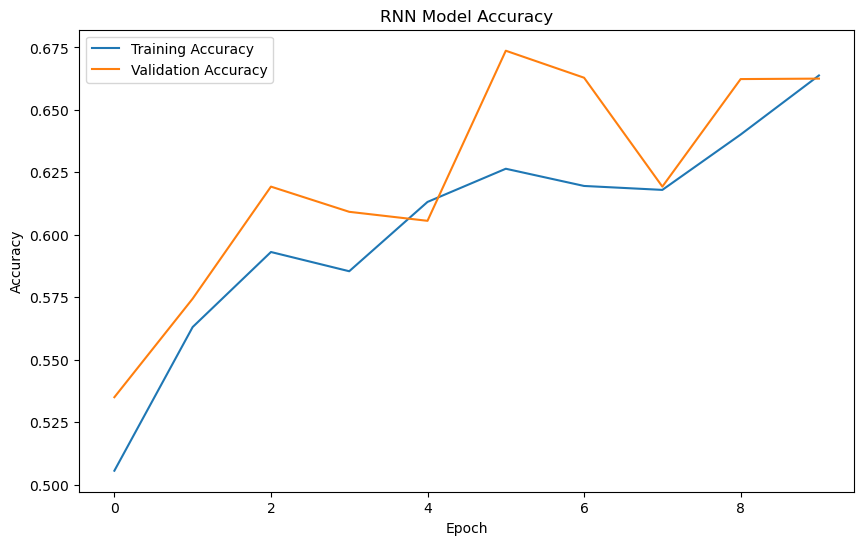

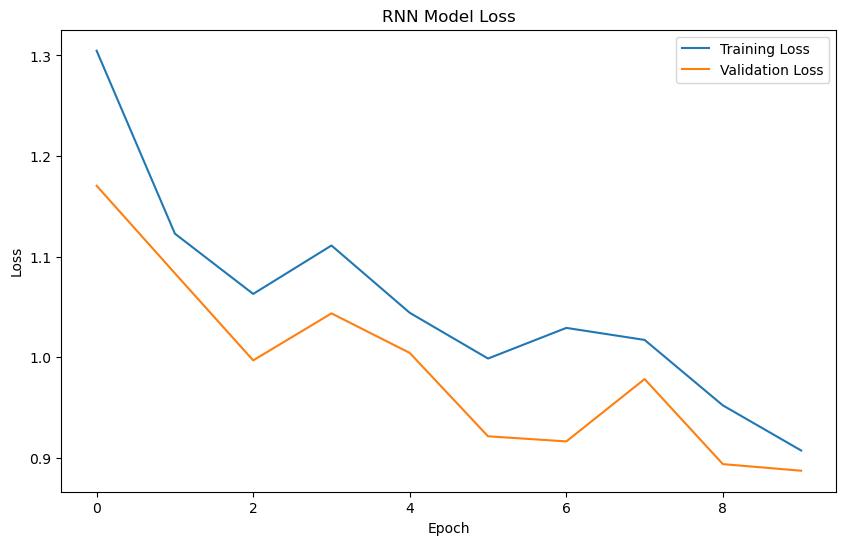

In [24]:
# Suppress the specific warning
warnings.filterwarnings("ignore", message="Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.")

# Existing model evaluation code
y_pred_rnn = np.argmax(rnn_model.predict(X_test), axis=1)
y_true_rnn = np.argmax(y_test, axis=1)

# Calculate Metrics with zero_division=1
precision_rnn = precision_score(y_true_rnn, y_pred_rnn, average='macro', zero_division=1)
recall_rnn = recall_score(y_true_rnn, y_pred_rnn, average='macro', zero_division=1)
f1_rnn = f1_score(y_true_rnn, y_pred_rnn, average='macro', zero_division=1)

# Calculate accuracy
accuracy_rnn = accuracy_score(y_true_rnn, y_pred_rnn)  # Calculate accuracy

# Print Metrics
print(f"RNN Model - Accuracy: {accuracy_rnn:.2f}, Precision: {precision_rnn:.2f}, Recall: {recall_rnn:.2f}, F1 Score: {f1_rnn:.2f}")

# Detailed Classification Report
print("\nClassification Report:\n", classification_report(y_true_rnn, y_pred_rnn))

# Plot Training & Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('RNN Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


# Deep Learning Model 3: CNN-RNN Hybrid Model for Human Activity Recognition (HAR) 

This document outlines the development and evaluation of a hybrid Convolutional Neural Network (CNN) and Recurrent Neural Network (RNN) model designed for recognizing human activities based on sensor data. The model leverages the spatial feature extraction capabilities of CNNs and the sequential data processing strengths of RNNs, making it well-suited for time-series sensor data analysis.

In [25]:
# Define the input shape
input_shape = (timesteps, features)

num_classes = 12  

# CNN part
cnn_input = Input(shape=input_shape)
cnn_layer = Conv1D(filters=64, kernel_size=3, activation='relu')(cnn_input)
cnn_layer = MaxPooling1D(pool_size=2)(cnn_layer)
cnn_layer = Flatten()(cnn_layer)

# RNN part
rnn_input = Input(shape=input_shape)
rnn_layer = LSTM(50, return_sequences=True)(rnn_input)
rnn_layer = Dropout(0.5)(rnn_layer)
rnn_layer = LSTM(50)(rnn_layer)
rnn_layer = Dropout(0.5)(rnn_layer)

# Merge CNN and RNN parts
merged_layer = concatenate([cnn_layer, rnn_layer])

# Fully connected layers
dense_layer = Dense(100, activation='relu')(merged_layer)
output_layer = Dense(num_classes, activation='softmax')(dense_layer)

# Create the hybrid model
hybrid_model = Model(inputs=[cnn_input, rnn_input], outputs=output_layer)
hybrid_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

## Model Training

In [26]:
# Model Training
history_hybrid = hybrid_model.fit([X_train, X_train], y_train, epochs=30, validation_data=([X_test, X_test], y_test), verbose=2)

Epoch 1/30
695/695 - 147s - loss: 1.0575 - accuracy: 0.5935 - val_loss: 0.9213 - val_accuracy: 0.6526 - 147s/epoch - 211ms/step
Epoch 2/30
695/695 - 134s - loss: 0.8119 - accuracy: 0.6890 - val_loss: 0.8970 - val_accuracy: 0.6694 - 134s/epoch - 193ms/step
Epoch 3/30
695/695 - 133s - loss: 0.7111 - accuracy: 0.7309 - val_loss: 0.8129 - val_accuracy: 0.6976 - 133s/epoch - 192ms/step
Epoch 4/30
695/695 - 132s - loss: 0.6448 - accuracy: 0.7552 - val_loss: 0.7618 - val_accuracy: 0.7167 - 132s/epoch - 189ms/step
Epoch 5/30
695/695 - 133s - loss: 0.5978 - accuracy: 0.7733 - val_loss: 0.7507 - val_accuracy: 0.7292 - 133s/epoch - 191ms/step
Epoch 6/30
695/695 - 135s - loss: 0.5496 - accuracy: 0.7939 - val_loss: 0.7485 - val_accuracy: 0.7419 - 135s/epoch - 194ms/step
Epoch 7/30
695/695 - 132s - loss: 0.5158 - accuracy: 0.8087 - val_loss: 0.7859 - val_accuracy: 0.7495 - 132s/epoch - 190ms/step
Epoch 8/30
695/695 - 134s - loss: 0.4849 - accuracy: 0.8203 - val_loss: 0.7791 - val_accuracy: 0.7412 - 

## Model Evaluation

174/174 [==============================] - 11s 62ms/step
Accuracy: 0.7601
Precision: 0.7611
Recall: 0.7601
F1 Score: 0.7601
Classification Report:
              precision    recall  f1-score   support

           4       0.90      0.87      0.88      1005
           6       0.65      0.61      0.63       983
           7       0.90      0.93      0.92       671
           8       0.62      0.57      0.59        72
           9       0.52      0.55      0.54       210
          10       0.77      0.77      0.77      1900
          11       0.65      0.72      0.69       712

    accuracy                           0.76      5553
   macro avg       0.72      0.72      0.72      5553
weighted avg       0.76      0.76      0.76      5553



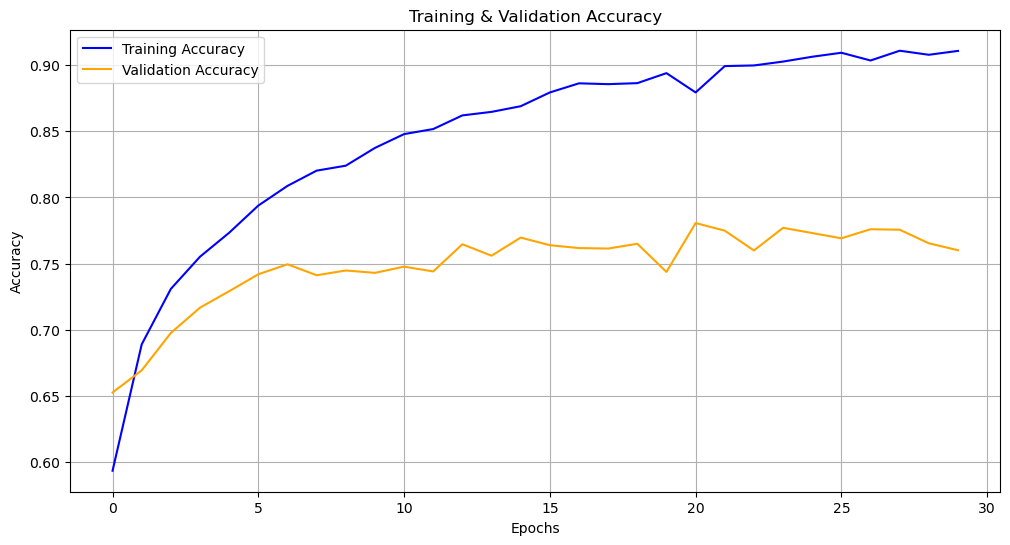

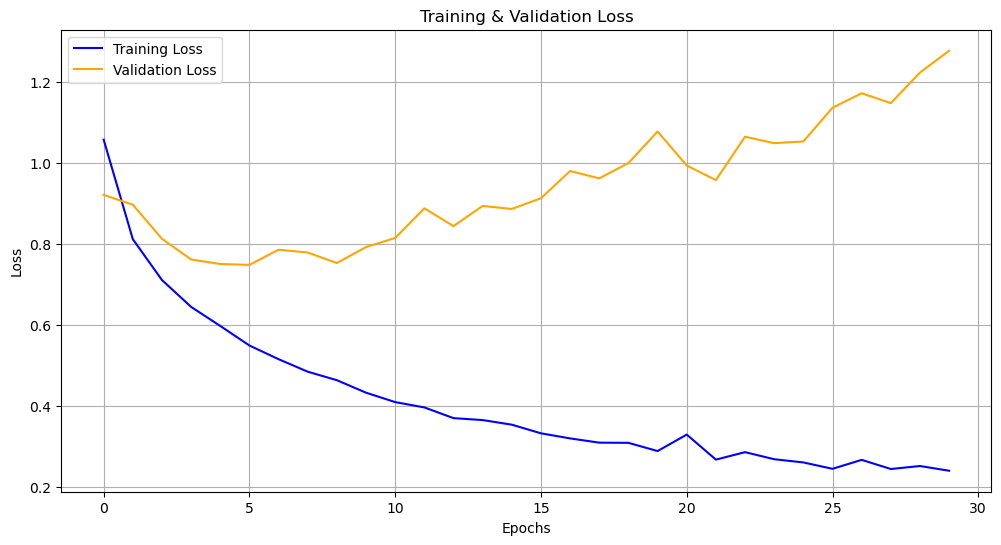

In [33]:
# Evaluate the hybrid model
y_pred = hybrid_model.predict([X_test, X_test])

# Convert one-hot encoded predictions to class labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Calculate Metrics with zero_division=1
accuracy = accuracy_score(y_true_labels, y_pred_labels)
precision = precision_score(y_true_labels, y_pred_labels, average='weighted', zero_division=1)
recall = recall_score(y_true_labels, y_pred_labels, average='weighted', zero_division=1)
f1 = f1_score(y_true_labels, y_pred_labels, average='weighted', zero_division=1)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed Classification Report
classification_rep = classification_report(y_true_labels, y_pred_labels)
print("Classification Report:")
print(classification_rep)

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_hybrid.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_hybrid.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training & Validation Loss
plt.figure(figsize=(12, 6))
plt.plot(history_hybrid.history['loss'], label='Training Loss', color='blue')
plt.plot(history_hybrid.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


# Model Comparison

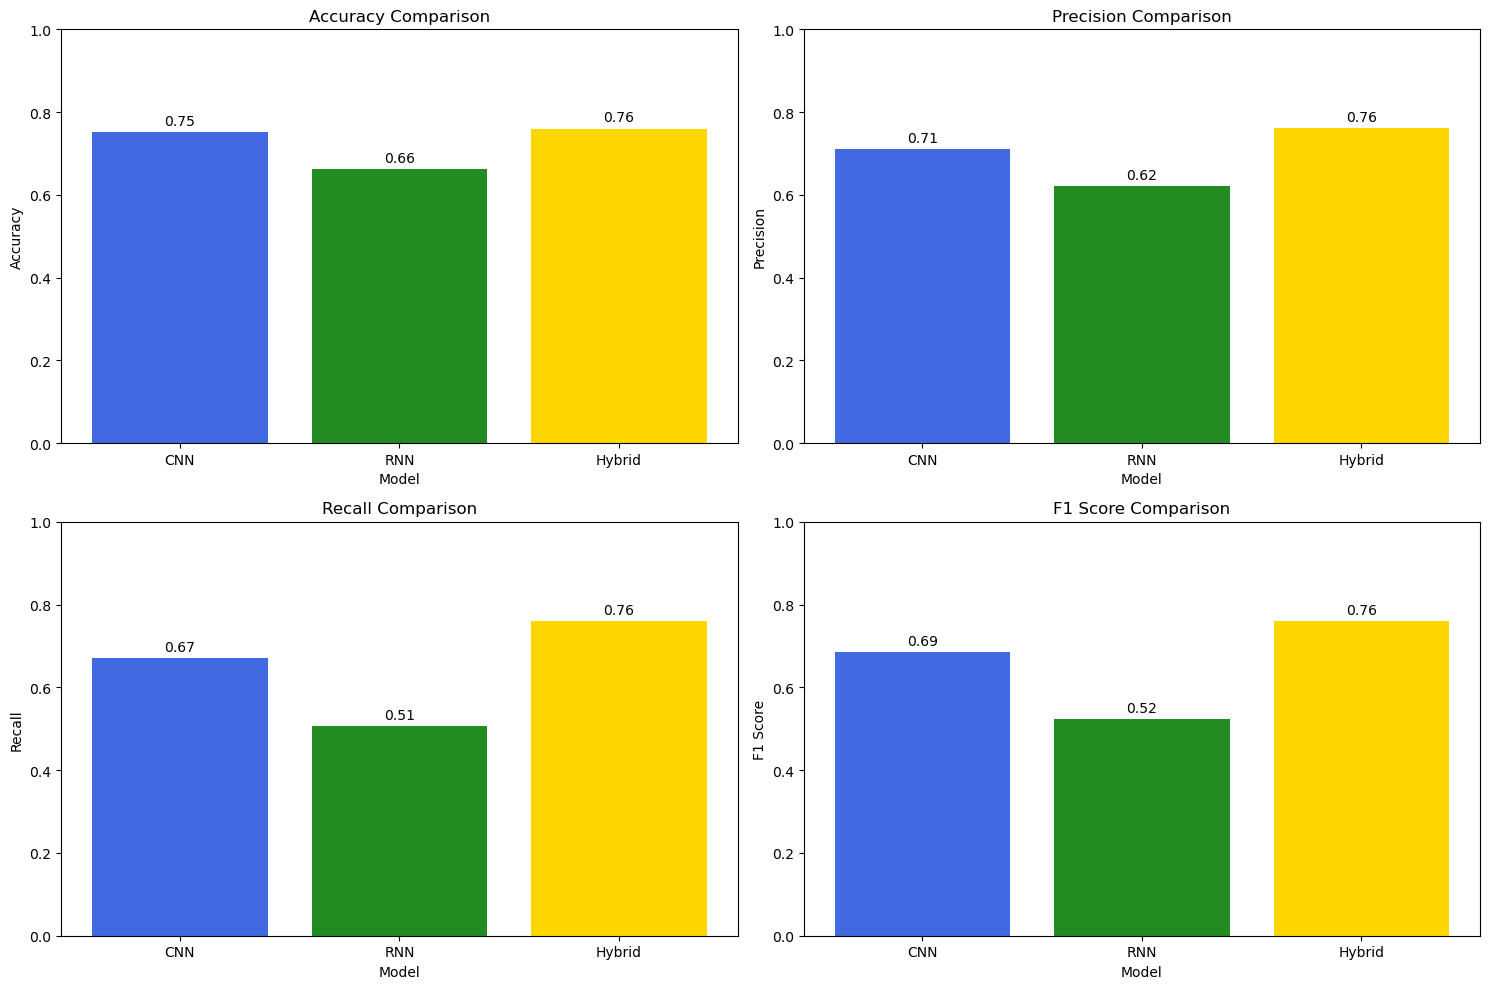

In [34]:
# Model Comparison
# Define the model names
model_names = ['CNN', 'RNN', 'Hybrid']

# Create dictionaries for each metric
accuracy = {'CNN': accuracy_cnn, 'RNN': accuracy_rnn, 'Hybrid': accuracy}
precision = {'CNN': precision_cnn, 'RNN': precision_rnn, 'Hybrid': precision}
recall = {'CNN': recall_cnn, 'RNN': recall_rnn, 'Hybrid': recall}
f1 = {'CNN': f1_cnn, 'RNN': f1_rnn, 'Hybrid': f1}

# Create subplots for each metric
metrics = [accuracy, precision, recall, f1]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

plt.figure(figsize=(15, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    bars = plt.bar(model_names, [metrics[i][model] for model in model_names], color=['royalblue', 'forestgreen', 'gold'])
    plt.ylim(0, 1)
    plt.title(f'{metric_names[i]} Comparison')
    plt.ylabel(metric_names[i])
    plt.xlabel('Model')

    # Add numerical values on top of each bar
    for model, bar in zip(model_names, bars):
        yval = metrics[i][model]
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom')

# Show the plots
plt.tight_layout()
plt.show()


# Deep Learning Model ConclusionThe hybrid CNN-RNN model demonstrates promising results in recognizing human activities from sensor data. Future work may explore further optimization of the model architecture, hyperparameter tuning, and the incorporation of additional data sources to enhance performance and robustnesss